### Deadline 2022-06-27 23:59:59

# Первая нейросетка

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
df = pd.read_csv('data.csv', index_col=0)

Как и в любой задаче машинного обучения для начала надо визуализировать данные. 
Не зря же нашу нейронную сеть мы так долго учим?


<AxesSubplot:xlabel='x1', ylabel='x2'>

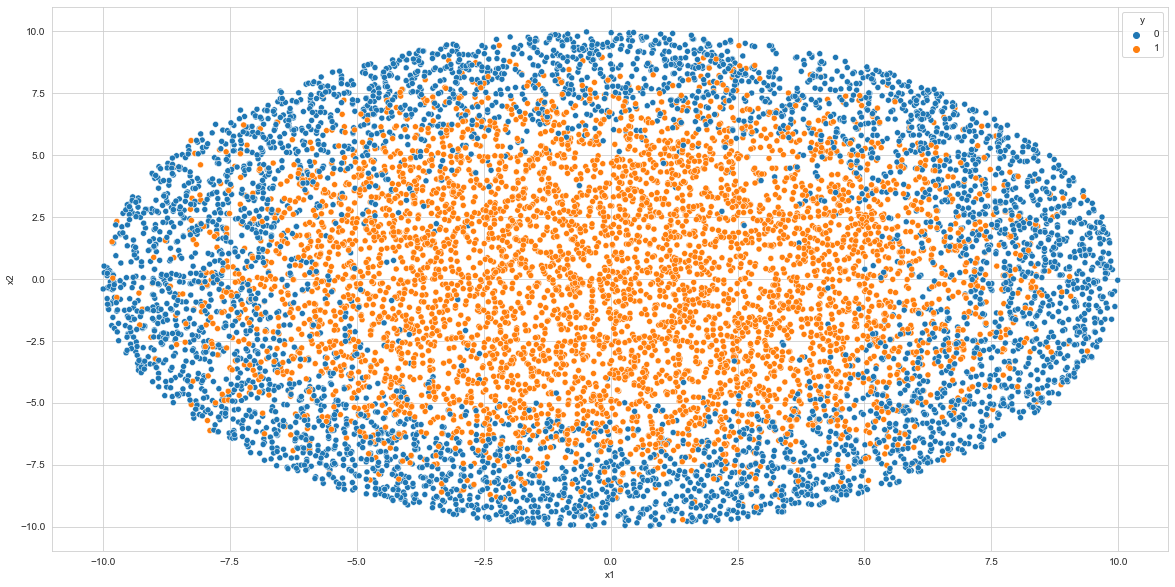

In [38]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data=df)

После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия. 

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# разобьем выборку на трэйн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['y'], test_size=0.33)

Точность нашей модели 0.5378787878787878


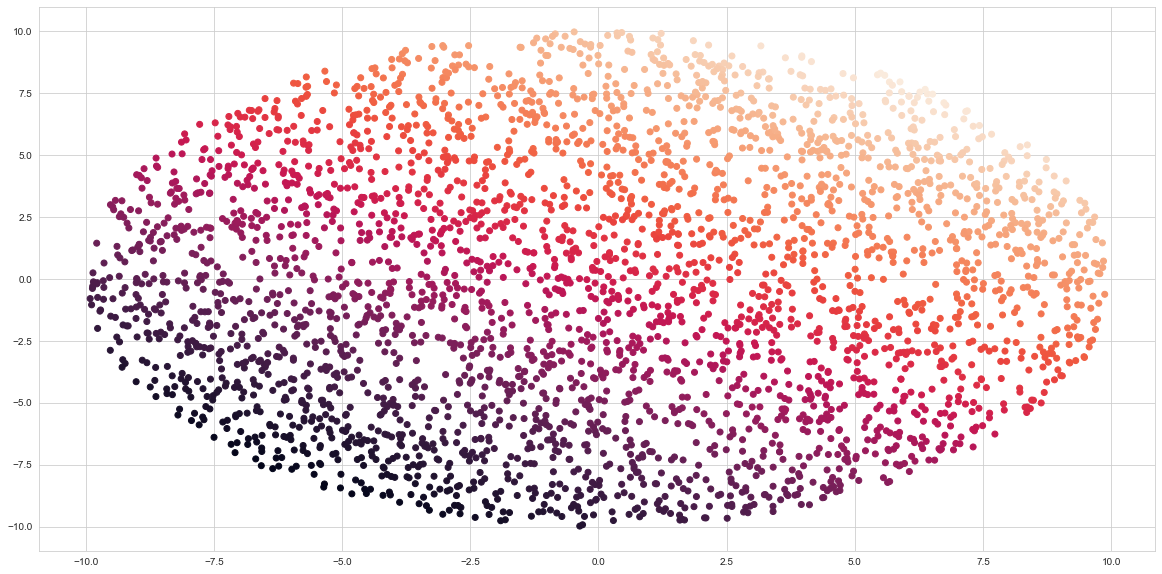

In [40]:
from sklearn.linear_model import LogisticRegression

#########################################
# Ваш код для Логистической регрессии

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

predict_logit = lr_model.predict(X_test)
predict_log_proba = lr_model.predict_log_proba(X_test)[:, 1]

#########################################


print(f'Точность нашей модели {accuracy_score(predict_logit, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(20, 10))
plt.scatter(X_test['x1'], X_test['x2'], c=predict_log_proba)
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

In [41]:
df.head(5)

x1        x2  y
0 -4.626272 -6.658988  0
1 -7.789640  0.262519  0
2 -8.739678  1.537758  0
3 -2.546441 -7.705224  0
4 -2.751506 -7.940187  0

In [42]:
df.describe()

x1            x2             y
count  10000.000000  10000.000000  10000.000000
mean      -0.029488     -0.098799      0.509700
std        4.981907      5.022414      0.499931
min       -9.988732     -9.972095      0.000000
25%       -4.062951     -4.170403      0.000000
50%       -0.063085     -0.097836      1.000000
75%        4.016095      3.880448      1.000000
max        9.985560      9.982304      1.000000

<AxesSubplot:>

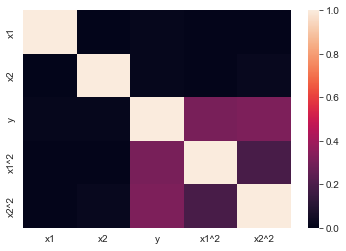

In [43]:
import seaborn as sb
# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()

#########################################
# ваш код для фичей и новой модели

#df_new['new_feature_1'] = df_new['x1']**2
df_new['x1^2'] = df_new['x1']**2
df_new['x2^2'] = df_new['x2']**2

sb.heatmap(abs(df_new.corr('kendall')), vmin=0, vmax=1)

Точность нашей модели 0.8448484848484848


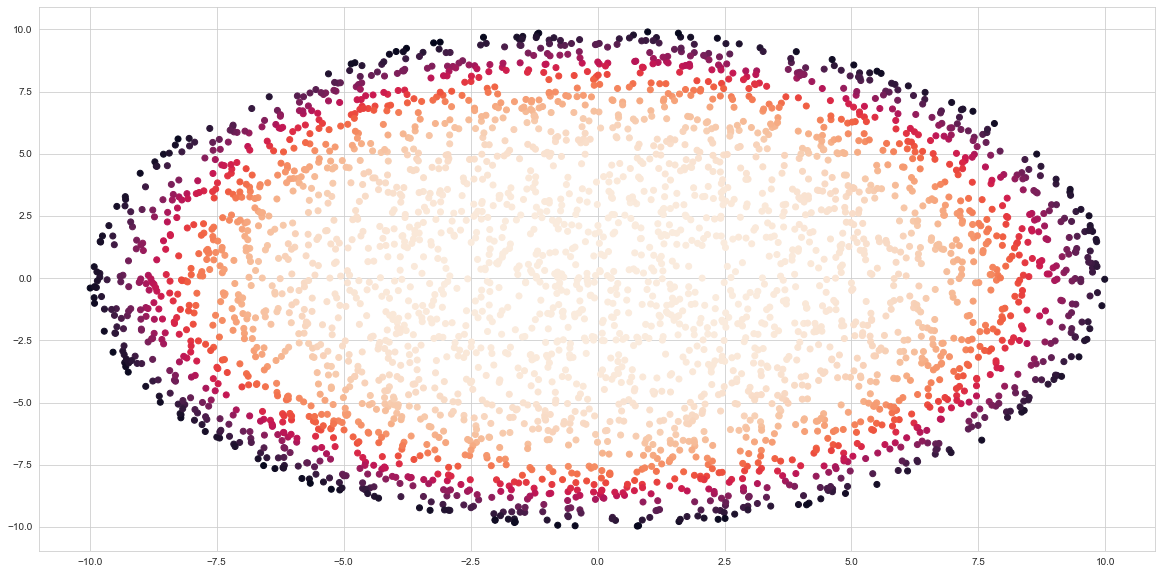

In [50]:

#X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'new_feature_1']],
# вдохновение по новым фичам получено здесь:
# https://stackoverflow.com/questions/42671089/is-there-any-module-for-non-linear-logistic-regression-in-python-sklearn

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'x1^2','x2^2']],
                                                                    df_new['y'], test_size=0.33)
lr_model_new = LogisticRegression()
lr_model_new.fit(X_train_new, y_train_new)
predict_logit = lr_model_new.predict(X_test_new)
predict_log_proba = lr_model_new.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Для того, чтоб совсем не списывать со счетов линейную регрессию, попробуем оптимизировать гиперпараметры с помощью библиотеки optuna

In [10]:
!pip install optuna
import optuna

In [51]:
# находим оптимальные параметры с помощью optuna

def lr_model_new_tr(trial: optuna.Trial) -> float:
    mi = trial.suggest_int(name='max_iter', low=100, high=100000)
    tl = trial.suggest_float(name='tol', low=1e-4, high=1)
    c = trial.suggest_float(name='C', low=1e-10, high=1000)
    cw = trial.suggest_categorical(name='class_weight', choices=['balanced', None])

    lr_model_mule = LogisticRegression(penalty='l2', max_iter=mi, tol=tl, C=c, class_weight=cw, solver='lbfgs').fit(
        X_train_new, y_train_new)
    pr = lr_model_mule.predict(X_test_new)
    score = accuracy_score(pr, y_test_new)

    return score


lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(lr_model_new_tr, n_trials=1000)

[I 2022-06-28 13:36:21,857] A new study created in memory with name: no-name-e0b5bb01-2fe5-46e5-b080-fb6ba27d6b4f
[I 2022-06-28 13:36:21,888] Trial 0 finished with value: 0.8448484848484848 and parameters: {'max_iter': 89963, 'tol': 0.8894876636836089, 'C': 876.3954113095617, 'class_weight': None}. Best is trial 0 with value: 0.8448484848484848.
[I 2022-06-28 13:36:21,909] Trial 1 finished with value: 0.843939393939394 and parameters: {'max_iter': 46558, 'tol': 0.5869385053084885, 'C': 186.799299394157, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8448484848484848.
[I 2022-06-28 13:36:21,928] Trial 2 finished with value: 0.843939393939394 and parameters: {'max_iter': 12234, 'tol': 0.06604327391359499, 'C': 114.7676234783285, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8448484848484848.
[I 2022-06-28 13:36:21,945] Trial 3 finished with value: 0.843939393939394 and parameters: {'max_iter': 3635, 'tol': 0.36665245929374674, 'C': 448.3046198493353, 'class_weigh

Подобрали 'max_iter': 73041, 'tol': 0.704545589235969, 'C': 962.0293158797763, 'class_weight': None

Точность нашей модели 0.8448484848484848


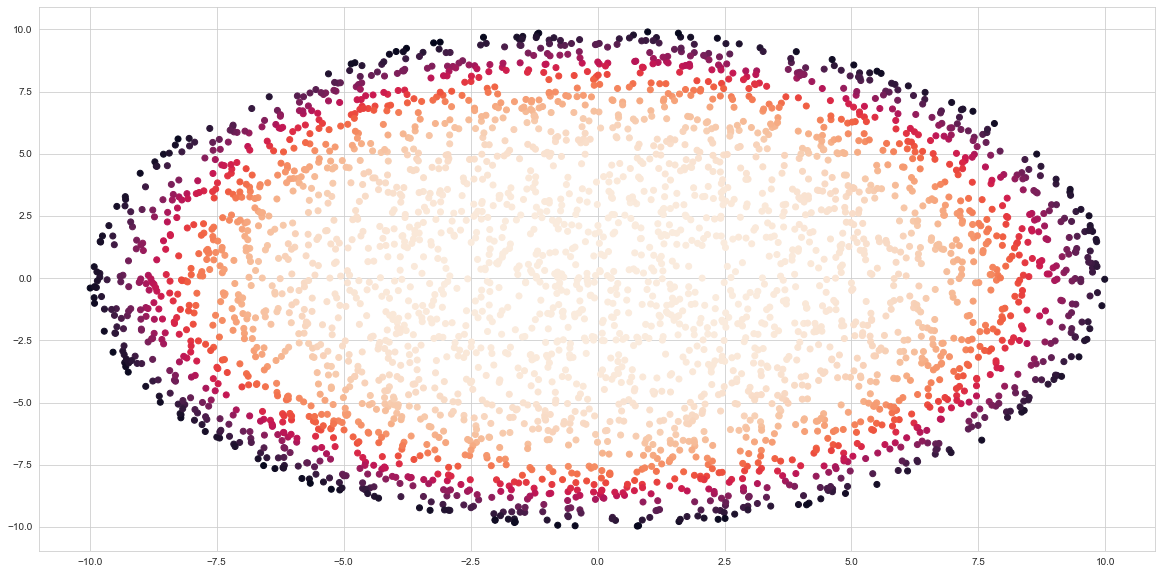

In [52]:
lr_model_neo = LogisticRegression(max_iter=73041, tol=0.704545589235969, C=962.0293158797763, class_weight=None)
lr_model_neo.fit(X_train_new, y_train_new)
predict_logit = lr_model_neo.predict(X_test_new)
predict_log_proba = lr_model_neo.predict_log_proba(X_test_new)[:, 1]

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test_new)}')

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_log_proba)
plt.show()

Переходим к следующему классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафиксировать, чтобы эта особенность не испортила обучение?

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
# с помощью optuna оптимизируем глубину
def tree_model_tr(trial: optuna.Trial) -> float:
    sp = trial.suggest_categorical(name='splitter', choices=['best', 'random'])
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)

    tree_model_mule = DecisionTreeClassifier(splitter=sp, max_depth=md, min_samples_split=ms, criterion='gini').fit(
        X_train_new, y_train_new)
    pr = tree_model_mule.predict(X_test_new)
    return accuracy_score(pr, y_test_new)


tree_study = optuna.create_study(direction='maximize')
tree_study.optimize(tree_model_tr, n_trials=1000)


[I 2022-06-28 13:44:24,804] A new study created in memory with name: no-name-cec8ef43-b9fc-4533-bda4-b504aeeb1644
[I 2022-06-28 13:44:24,818] Trial 0 finished with value: 0.7821212121212121 and parameters: {'splitter': 'random', 'max_depth': 69, 'min_samples_split': 4}. Best is trial 0 with value: 0.7821212121212121.
[I 2022-06-28 13:44:24,828] Trial 1 finished with value: 0.786060606060606 and parameters: {'splitter': 'random', 'max_depth': 39, 'min_samples_split': 6}. Best is trial 1 with value: 0.786060606060606.
[I 2022-06-28 13:44:24,840] Trial 2 finished with value: 0.7884848484848485 and parameters: {'splitter': 'random', 'max_depth': 44, 'min_samples_split': 7}. Best is trial 2 with value: 0.7884848484848485.
[I 2022-06-28 13:44:24,847] Trial 3 finished with value: 0.8296969696969697 and parameters: {'splitter': 'random', 'max_depth': 7, 'min_samples_split': 5}. Best is trial 3 with value: 0.8296969696969697.
[I 2022-06-28 13:44:24,856] Trial 4 finished with value: 0.7845454545

Подобраны параметры: 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 5

Точность нашей модели 0.8403030303030303


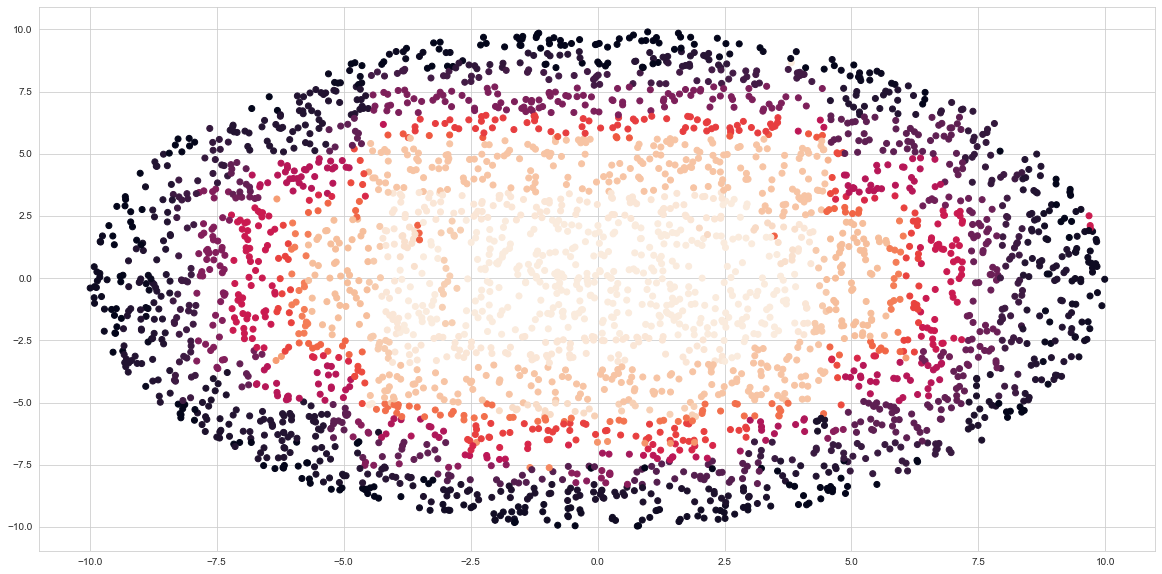

In [98]:
#########################################
# Ваш код

tree_model = DecisionTreeClassifier(splitter='random', max_depth=7, min_samples_split=5)
tree_model.fit(X_train_new, y_train_new)

predict_tree = tree_model.predict(X_test_new)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test_new)}')

predict_tree_proba = tree_model.predict_proba(X_test_new)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_tree_proba)
plt.show()

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
# очень нравится optuna применю её и здесь
def forest_model_tr(trial: optuna.Trial) -> float:
    n = trial.suggest_int(name='n_estimators', low=10, high=1000)
    ms = trial.suggest_int(name='min_samples_split', low=2, high=10, step=1)
    md = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    bs = trial.suggest_categorical(name='bootstrap', choices=[True, False])

    forest_model_mule = RandomForestClassifier(n_estimators=n, criterion='gini', min_samples_split=ms, max_depth=md,
                                               bootstrap=bs).fit(X_train_new, y_train_new)
    pr = forest_model_mule.predict(X_test_new)
    return accuracy_score(pr, y_test_new)


forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(forest_model_tr, n_trials=100)

[I 2022-06-28 13:49:44,301] A new study created in memory with name: no-name-3c9a80f9-06aa-4bb0-a1ce-389f2af56399
[I 2022-06-28 13:49:45,560] Trial 0 finished with value: 0.8109090909090909 and parameters: {'n_estimators': 69, 'min_samples_split': 10, 'max_depth': 96, 'bootstrap': False}. Best is trial 0 with value: 0.8109090909090909.
[I 2022-06-28 13:49:49,999] Trial 1 finished with value: 0.8257575757575758 and parameters: {'n_estimators': 492, 'min_samples_split': 6, 'max_depth': 83, 'bootstrap': True}. Best is trial 1 with value: 0.8257575757575758.
[I 2022-06-28 13:49:59,909] Trial 2 finished with value: 0.7981818181818182 and parameters: {'n_estimators': 685, 'min_samples_split': 2, 'max_depth': 31, 'bootstrap': False}. Best is trial 1 with value: 0.8257575757575758.
[I 2022-06-28 13:50:04,083] Trial 3 finished with value: 0.8445454545454546 and parameters: {'n_estimators': 632, 'min_samples_split': 8, 'max_depth': 7, 'bootstrap': True}. Best is trial 3 with value: 0.84454545454

Подобраны параметры: 'n_estimators': 695, 'min_samples_split': 6, 'max_depth': 6, 'bootstrap': False

Точность нашей модели 0.8478787878787879


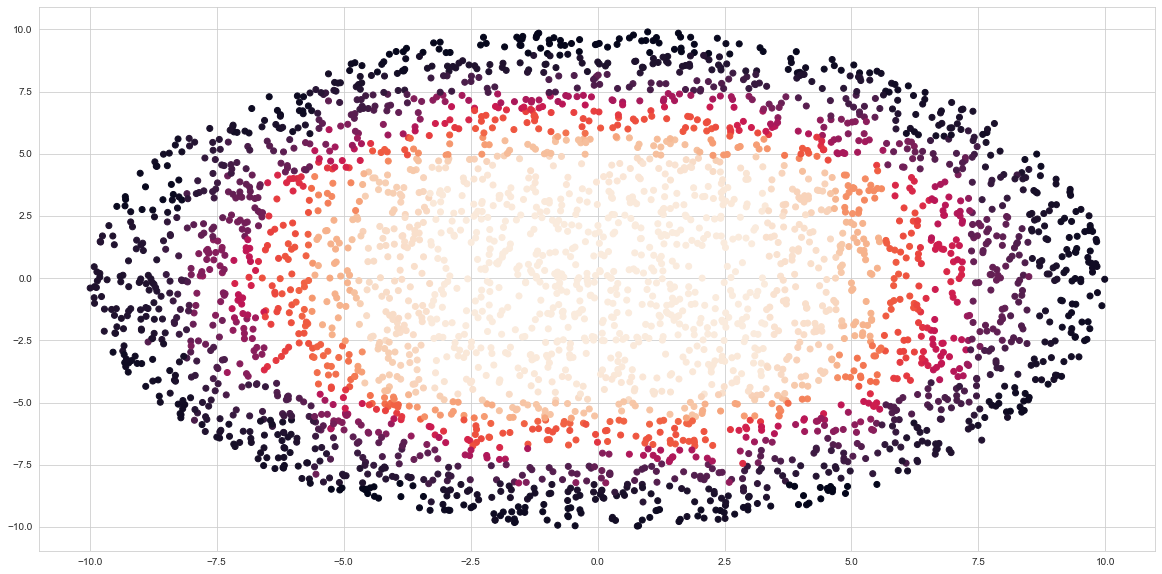

In [100]:
#########################################
# Ваш код

forest_model = RandomForestClassifier(n_estimators=695, criterion='gini', min_samples_split=6, max_depth=6,
                                      bootstrap=False)
forest_model.fit(X_train_new, y_train_new)
predict_forest = forest_model.predict(X_test_new)
print(f'Точность нашей модели {accuracy_score(predict_forest, y_test_new)}')

predict_forest_proba = forest_model.predict_proba(X_test_new)[:, 1]

#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_forest_proba)
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом. Смотрим на предыдущую тетрадку и копипастим все, что мы там видим! (можно для убыстрения процесса добавить callback с ранней остановкой)

In [16]:
!pip install tensorflow

In [101]:
# Подгружаем tensorflow 
import tensorflow as tf

keras = tf.keras

print(tf.__version__)
print(keras.__version__)

from tensorflow.keras.models import Sequential  # Последовательность слоёв
import tensorflow.keras.layers as L  # Разные слои
import tensorflow.keras.optimizers as opt  # Оптимизаторы

2.9.1
2.9.0


На этом наше приключение сегодня закончилось. Вопросы максимально желательны :)

104/104 [==============================] - 0s 611us/step
Точность нашей модели 0.5118181818181818


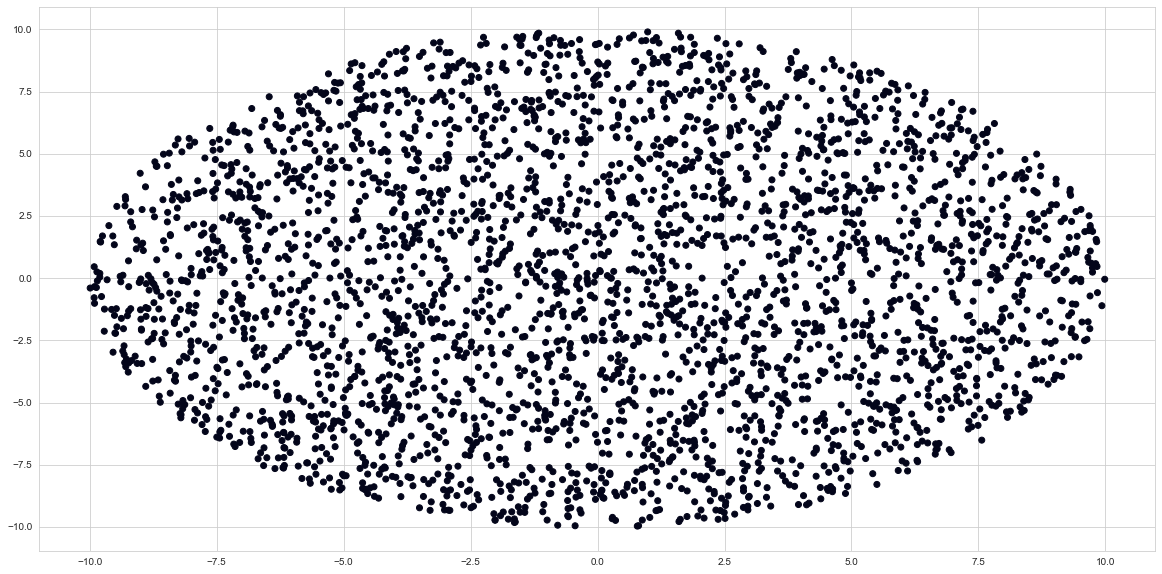

In [105]:
#########################################
# Ваш код

def get_neural_model():
    neural_model = Sequential()
    neural_model.add(L.Dense(5, input_dim=X_test_new.shape[1], kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(5, kernel_initializer='random_normal'))
    neural_model.add(L.Activation('sigmoid'))
    neural_model.add(L.Dense(2, activation='softmax', kernel_initializer='random_normal'))
    optimizer = opt.Adam(learning_rate=1e-3)

    neural_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return neural_model


my_first_neural_model = get_neural_model()
my_first_neural_model.fit(X_train_new, keras.utils.to_categorical(y_train_new))

predict_neural = my_first_neural_model.predict(X_test_new)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

print(f'Точность нашей модели {accuracy_score(predict_classes, y_test_new)}')
#########################################

plt.figure(figsize=(20, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_classes)
plt.show()

Epoch 1/38
210/210 [==============================] - 1s 1ms/step - loss: 0.6744 - accuracy: 0.6094
Epoch 2/38
210/210 [==============================] - 0s 869us/step - loss: 0.6061 - accuracy: 0.6655
Epoch 3/38
210/210 [==============================] - 0s 936us/step - loss: 0.5518 - accuracy: 0.6875
Epoch 4/38
210/210 [==============================] - 0s 883us/step - loss: 0.5347 - accuracy: 0.7031
Epoch 5/38
210/210 [==============================] - 0s 1ms/step - loss: 0.5362 - accuracy: 0.7248
Epoch 6/38
210/210 [==============================] - 0s 880us/step - loss: 0.5165 - accuracy: 0.7388
Epoch 7/38
210/210 [==============================] - 0s 973us/step - loss: 0.5151 - accuracy: 0.7497
Epoch 8/38
210/210 [==============================] - 0s 956us/step - loss: 0.5091 - accuracy: 0.7467
Epoch 9/38
210/210 [==============================] - 0s 841us/step - loss: 0.5079 - accuracy: 0.7557
Epoch 10/38
210/210 [==============================] - 0s 823us/step - loss: 0.5063 - 

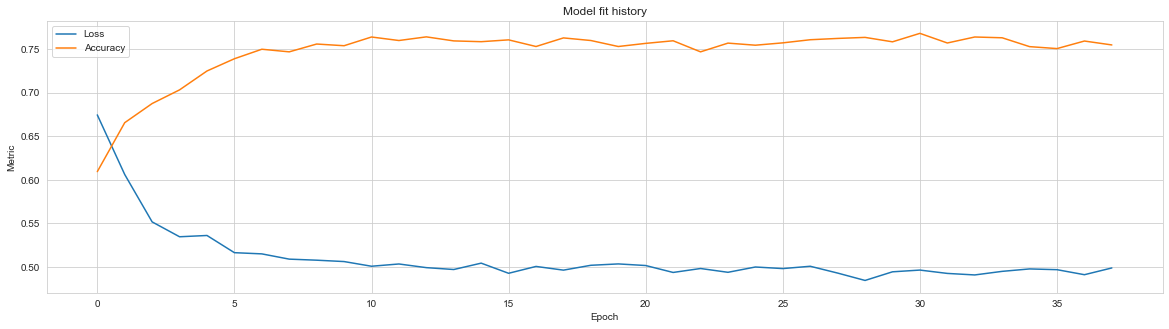

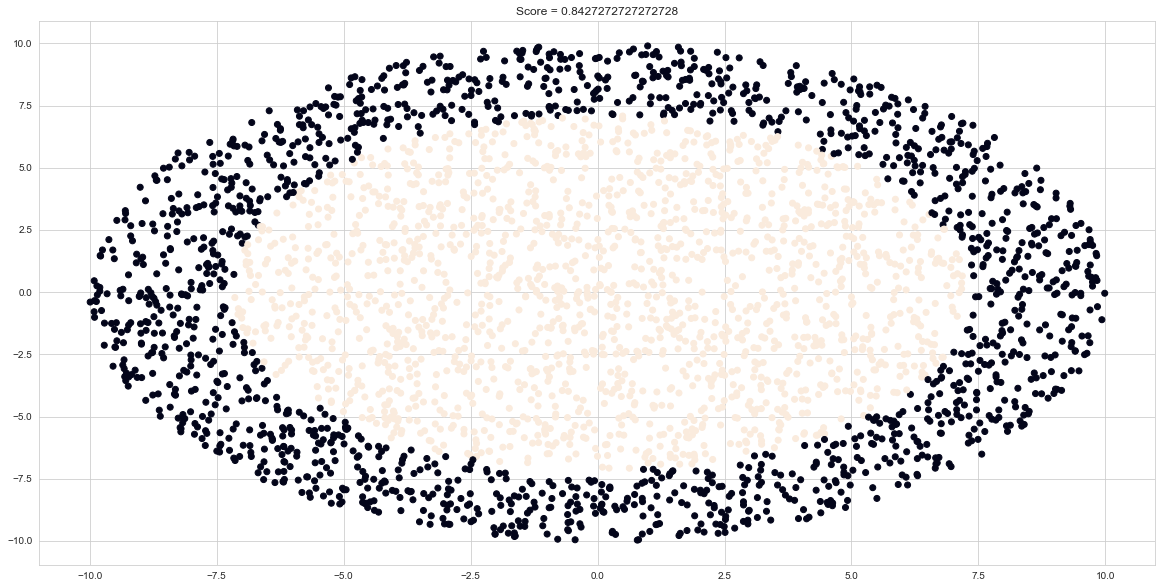

In [106]:
# предыдущая сеть - действительно первая нейронная сеть написанная мной по принципу copy->paste и заставь работать,
# однако результат её назвать удовлетворительным нельзя, поэтому проведу работу над улучшением её результата
from sklearn.preprocessing import StandardScaler


#########################################

def get_neural_model_neo():
    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test_new.shape[1]))

    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_normal'))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_normal'))
    neural_model.add(L.Dropout(0.5))

    neural_model.add(L.Dense(2, activation='sigmoid'))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train_new)
X_train_std = std_scaler.transform(X_train_new)
X_test_std = std_scaler.transform(X_test_new)

my_first_neural_model = get_neural_model_neo()
fit_log = my_first_neural_model.fit(X_train_std, keras.utils.to_categorical(y_train_new), epochs=38, workers=4, verbose=1)

predict_neural = my_first_neural_model.predict(X_test_std)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

score = accuracy_score(predict_classes, y_test_new)

print(f'Точность нашей модели {score}')
#########################################
plt.figure(figsize=(20, 5))
plt.title(f'Model fit history')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.plot(fit_log.history['loss'], label='Loss')
plt.plot(fit_log.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title(f'Score = {score}')
plt.scatter(X_test_new['x1'], X_test_new['x2'], c=predict_classes)
plt.show()

In [107]:
# оптимизация с помощью optuna
def get_neural_model_optimized(trial: optuna.Trial) -> Sequential():
    activator_choices = ['relu', 'sigmoid', 'softmax', 'tanh']

    kernel_initializer_choices = ['random_normal', 'random_uniform', 'zeros', 'ones']

    opt_activator1 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_activator2 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_activator3 = trial.suggest_categorical(name='activation', choices=activator_choices)
    opt_kernel_init1 = trial.suggest_categorical(name='kernel_initializer', choices=kernel_initializer_choices)
    opt_kernel_init2 = trial.suggest_categorical(name='kernel_initializer', choices=kernel_initializer_choices)

    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test_new.shape[1]))

    neural_model.add(L.Dense(5, activation=opt_activator1, kernel_initializer=opt_kernel_init1))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation=opt_activator2, kernel_initializer=opt_kernel_init2))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(2, activation=opt_activator3))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


def neuro_model_tr(trial: optuna.Trial) -> float:
    keras.backend.clear_session()
    opt_batch_size = trial.suggest_int(name='batch_size', low=30, high=150)
    opt_epoch_count = trial.suggest_int(name='epochs', low=30, high=100)

    neuro_model = get_neural_model_optimized(trial)

    neuro_model.fit(X_train_std, keras.utils.to_categorical(y_train_new), batch_size=opt_batch_size, epochs=38, workers=4,
                    verbose=1)

    score = neuro_model.evaluate(X_test_std, keras.utils.to_categorical(y_test_new), verbose=0)
    return score[1]


study = optuna.create_study(direction="maximize")
study.optimize(neuro_model_tr, n_trials=100)

[I 2022-06-28 14:06:45,047] A new study created in memory with name: no-name-f4532be2-17c6-4d26-a870-07c43853da6c


Epoch 1/38
75/75 [==============================] - 1s 1ms/step - loss: 1.3059 - accuracy: 0.4909
Epoch 2/38
75/75 [==============================] - 0s 972us/step - loss: 0.8269 - accuracy: 0.5006
Epoch 3/38
75/75 [==============================] - 0s 944us/step - loss: 0.7508 - accuracy: 0.5257
Epoch 4/38
75/75 [==============================] - 0s 910us/step - loss: 0.7145 - accuracy: 0.5857
Epoch 5/38
75/75 [==============================] - 0s 1ms/step - loss: 0.6864 - accuracy: 0.6607
Epoch 6/38
75/75 [==============================] - 0s 1ms/step - loss: 0.6703 - accuracy: 0.6921
Epoch 7/38
75/75 [==============================] - 0s 910us/step - loss: 0.6588 - accuracy: 0.6969
Epoch 8/38
75/75 [==============================] - 0s 968us/step - loss: 0.6353 - accuracy: 0.7093
Epoch 9/38
75/75 [==============================] - 0s 952us/step - loss: 0.6319 - accuracy: 0.7210
Epoch 10/38
75/75 [==============================] - 0s 887us/step - loss: 0.6380 - accuracy: 0.7281
Epoch

[I 2022-06-28 14:06:48,518] Trial 0 finished with value: 0.835454523563385 and parameters: {'batch_size': 90, 'epochs': 41, 'activation': 'relu', 'kernel_initializer': 'random_normal'}. Best is trial 0 with value: 0.835454523563385.


Epoch 1/38
49/49 [==============================] - 0s 966us/step - loss: 0.7037 - accuracy: 0.4931
Epoch 2/38
49/49 [==============================] - 0s 963us/step - loss: 0.6975 - accuracy: 0.5145
Epoch 3/38
49/49 [==============================] - 0s 944us/step - loss: 0.6986 - accuracy: 0.5054
Epoch 4/38
49/49 [==============================] - 0s 951us/step - loss: 0.6962 - accuracy: 0.5094
Epoch 5/38
49/49 [==============================] - 0s 961us/step - loss: 0.6966 - accuracy: 0.5143
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.5319
Epoch 7/38
49/49 [==============================] - 0s 912us/step - loss: 0.6887 - accuracy: 0.5452
Epoch 8/38
49/49 [==============================] - 0s 931us/step - loss: 0.6859 - accuracy: 0.5542
Epoch 9/38
49/49 [==============================] - 0s 912us/step - loss: 0.6836 - accuracy: 0.5597
Epoch 10/38
49/49 [==============================] - 0s 906us/step - loss: 0.6791 - accuracy: 0.5748
E

[I 2022-06-28 14:06:51,019] Trial 1 finished with value: 0.8448485136032104 and parameters: {'batch_size': 139, 'epochs': 89, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
52/52 [==============================] - 1s 1ms/step - loss: 0.7372 - accuracy: 0.4996
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7256 - accuracy: 0.4957
Epoch 3/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7164 - accuracy: 0.5063
Epoch 4/38
52/52 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.5039
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7089 - accuracy: 0.5072
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7017 - accuracy: 0.5133
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7006 - accuracy: 0.5166
Epoch 8/38
52/52 [==============================] - 0s 926us/step - loss: 0.6977 - accuracy: 0.5182
Epoch 9/38
52/52 [==============================] - 0s 845us/step - loss: 0.6980 - accuracy: 0.5133
Epoch 10/38
52/52 [==============================] - 0s 839us/step - loss: 0.6967 - accuracy: 0.5125
Epoch 11/38
5

[I 2022-06-28 14:06:53,757] Trial 2 finished with value: 0.8427272439002991 and parameters: {'batch_size': 131, 'epochs': 100, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
45/45 [==============================] - 1s 918us/step - loss: 1.8675 - accuracy: 0.5115
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 1.1893 - accuracy: 0.5121
Epoch 3/38
45/45 [==============================] - 0s 939us/step - loss: 0.9086 - accuracy: 0.5137
Epoch 4/38
45/45 [==============================] - 0s 978us/step - loss: 0.8078 - accuracy: 0.5240
Epoch 5/38
45/45 [==============================] - 0s 958us/step - loss: 0.7531 - accuracy: 0.5303
Epoch 6/38
45/45 [==============================] - 0s 922us/step - loss: 0.7201 - accuracy: 0.6003
Epoch 7/38
45/45 [==============================] - 0s 894us/step - loss: 0.6757 - accuracy: 0.6455
Epoch 8/38
45/45 [==============================] - 0s 862us/step - loss: 0.6550 - accuracy: 0.6800
Epoch 9/38
45/45 [==============================] - 0s 898us/step - loss: 0.6459 - accuracy: 0.7279
Epoch 10/38
45/45 [==============================] - 0s 860us/step - loss: 0.6331 - accuracy: 0.7403
E

[I 2022-06-28 14:06:56,132] Trial 3 finished with value: 0.8348484635353088 and parameters: {'batch_size': 149, 'epochs': 32, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
66/66 [==============================] - 0s 966us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 2/38
66/66 [==============================] - 0s 941us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 3/38
66/66 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 4/38
66/66 [==============================] - 0s 945us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 5/38
66/66 [==============================] - 0s 910us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 6/38
66/66 [==============================] - 0s 928us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 7/38
66/66 [==============================] - 0s 873us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 8/38
66/66 [==============================] - 0s 947us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 9/38
66/66 [==============================] - 0s 869us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 10/38
66/66 [==============================] - 0s 872us/step - loss: 7.7125 - accuracy: 0.4913
E

[I 2022-06-28 14:06:59,126] Trial 4 finished with value: 0.48818182945251465 and parameters: {'batch_size': 102, 'epochs': 62, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
66/66 [==============================] - 0s 943us/step - loss: 0.7292 - accuracy: 0.4964
Epoch 2/38
66/66 [==============================] - 0s 908us/step - loss: 0.7161 - accuracy: 0.4985
Epoch 3/38
66/66 [==============================] - 0s 912us/step - loss: 0.7069 - accuracy: 0.5040
Epoch 4/38
66/66 [==============================] - 0s 981us/step - loss: 0.7033 - accuracy: 0.5101
Epoch 5/38
66/66 [==============================] - 0s 888us/step - loss: 0.7011 - accuracy: 0.5128
Epoch 6/38
66/66 [==============================] - 0s 911us/step - loss: 0.6950 - accuracy: 0.5219
Epoch 7/38
66/66 [==============================] - 0s 901us/step - loss: 0.6917 - accuracy: 0.5363
Epoch 8/38
66/66 [==============================] - 0s 850us/step - loss: 0.6900 - accuracy: 0.5288
Epoch 9/38
66/66 [==============================] - 0s 865us/step - loss: 0.6847 - accuracy: 0.5546
Epoch 10/38
66/66 [==============================] - 0s 852us/step - loss: 0.6839 - accuracy: 0.5649

[I 2022-06-28 14:07:02,110] Trial 5 finished with value: 0.8393939137458801 and parameters: {'batch_size': 103, 'epochs': 47, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
74/74 [==============================] - 1s 957us/step - loss: 0.7610 - accuracy: 0.4999
Epoch 2/38
74/74 [==============================] - 0s 970us/step - loss: 0.7301 - accuracy: 0.5024
Epoch 3/38
74/74 [==============================] - 0s 982us/step - loss: 0.7149 - accuracy: 0.4981
Epoch 4/38
74/74 [==============================] - 0s 938us/step - loss: 0.7074 - accuracy: 0.4955
Epoch 5/38
74/74 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5228
Epoch 6/38
74/74 [==============================] - 0s 987us/step - loss: 0.6972 - accuracy: 0.5172
Epoch 7/38
74/74 [==============================] - 0s 902us/step - loss: 0.6951 - accuracy: 0.5319
Epoch 8/38
74/74 [==============================] - 0s 955us/step - loss: 0.6921 - accuracy: 0.5446
Epoch 9/38
74/74 [==============================] - 0s 979us/step - loss: 0.6894 - accuracy: 0.5597
Epoch 10/38
74/74 [==============================] - 0s 930us/step - loss: 0.6853 - accuracy: 0.5781
E

[I 2022-06-28 14:07:05,405] Trial 6 finished with value: 0.8399999737739563 and parameters: {'batch_size': 91, 'epochs': 89, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
64/64 [==============================] - 0s 972us/step - loss: 0.7012 - accuracy: 0.5016
Epoch 2/38
64/64 [==============================] - 0s 950us/step - loss: 0.7000 - accuracy: 0.4949
Epoch 3/38
64/64 [==============================] - 0s 972us/step - loss: 0.6984 - accuracy: 0.5039
Epoch 4/38
64/64 [==============================] - 0s 966us/step - loss: 0.6963 - accuracy: 0.5110
Epoch 5/38
64/64 [==============================] - 0s 934us/step - loss: 0.6940 - accuracy: 0.5203
Epoch 6/38
64/64 [==============================] - 0s 935us/step - loss: 0.6918 - accuracy: 0.5284
Epoch 7/38
64/64 [==============================] - 0s 885us/step - loss: 0.6883 - accuracy: 0.5422
Epoch 8/38
64/64 [==============================] - 0s 905us/step - loss: 0.6847 - accuracy: 0.5599
Epoch 9/38
64/64 [==============================] - 0s 880us/step - loss: 0.6795 - accuracy: 0.5703
Epoch 10/38
64/64 [==============================] - 0s 874us/step - loss: 0.6747 - accuracy: 0.5788

[I 2022-06-28 14:07:08,304] Trial 7 finished with value: 0.8445454835891724 and parameters: {'batch_size': 105, 'epochs': 36, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
127/127 [==============================] - 1s 920us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 2/38
127/127 [==============================] - 0s 856us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 3/38
127/127 [==============================] - 0s 888us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 4/38
127/127 [==============================] - 0s 866us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 5/38
127/127 [==============================] - 0s 914us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 6/38
127/127 [==============================] - 0s 860us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 7/38
127/127 [==============================] - 0s 828us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 8/38
127/127 [==============================] - 0s 821us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 9/38
127/127 [==============================] - 0s 823us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 10/38
127/127 [==============================] - 0s 866us/step - loss: 7.712

[I 2022-06-28 14:07:13,162] Trial 8 finished with value: 0.48818182945251465 and parameters: {'batch_size': 53, 'epochs': 53, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
82/82 [==============================] - 0s 925us/step - loss: 0.7192 - accuracy: 0.5028
Epoch 2/38
82/82 [==============================] - 0s 903us/step - loss: 0.7103 - accuracy: 0.5030
Epoch 3/38
82/82 [==============================] - 0s 958us/step - loss: 0.7051 - accuracy: 0.4996
Epoch 4/38
82/82 [==============================] - 0s 900us/step - loss: 0.6993 - accuracy: 0.5060
Epoch 5/38
82/82 [==============================] - 0s 887us/step - loss: 0.6974 - accuracy: 0.5039
Epoch 6/38
82/82 [==============================] - 0s 907us/step - loss: 0.6941 - accuracy: 0.5096
Epoch 7/38
82/82 [==============================] - 0s 841us/step - loss: 0.6905 - accuracy: 0.5248
Epoch 8/38
82/82 [==============================] - 0s 837us/step - loss: 0.6859 - accuracy: 0.5422
Epoch 9/38
82/82 [==============================] - 0s 840us/step - loss: 0.6775 - accuracy: 0.5745
Epoch 10/38
82/82 [==============================] - 0s 906us/step - loss: 0.6736 - accuracy: 0.5857

[I 2022-06-28 14:07:16,676] Trial 9 finished with value: 0.8409090638160706 and parameters: {'batch_size': 82, 'epochs': 83, 'activation': 'sigmoid', 'kernel_initializer': 'random_normal'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
153/153 [==============================] - 1s 1ms/step - loss: 3.4926 - accuracy: 0.6654
Epoch 2/38
153/153 [==============================] - 0s 1ms/step - loss: 3.3173 - accuracy: 0.6687
Epoch 3/38
153/153 [==============================] - 0s 931us/step - loss: 3.1539 - accuracy: 0.6764
Epoch 4/38
153/153 [==============================] - 0s 864us/step - loss: 2.9599 - accuracy: 0.6809
Epoch 5/38
153/153 [==============================] - 0s 889us/step - loss: 2.8946 - accuracy: 0.6867
Epoch 6/38
153/153 [==============================] - 0s 850us/step - loss: 2.7088 - accuracy: 0.6896
Epoch 7/38
153/153 [==============================] - 0s 871us/step - loss: 2.6259 - accuracy: 0.6927
Epoch 8/38
153/153 [==============================] - 0s 836us/step - loss: 2.4886 - accuracy: 0.7046
Epoch 9/38
153/153 [==============================] - 0s 885us/step - loss: 2.1362 - accuracy: 0.7109
Epoch 10/38
153/153 [==============================] - 0s 829us/step - loss: 1.8185 - 

[I 2022-06-28 14:07:22,527] Trial 10 finished with value: 0.8418181538581848 and parameters: {'batch_size': 44, 'epochs': 76, 'activation': 'tanh', 'kernel_initializer': 'ones'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7057 - accuracy: 0.4893
Epoch 2/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.4930
Epoch 3/38
53/53 [==============================] - 0s 938us/step - loss: 0.6958 - accuracy: 0.5016
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6947 - accuracy: 0.5036
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.4979
Epoch 6/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.4984
Epoch 7/38
53/53 [==============================] - 0s 991us/step - loss: 0.6945 - accuracy: 0.4942
Epoch 8/38
53/53 [==============================] - 0s 917us/step - loss: 0.6937 - accuracy: 0.5045
Epoch 9/38
53/53 [==============================] - 0s 987us/step - loss: 0.6928 - accuracy: 0.5188
Epoch 10/38
53/53 [==============================] - 0s 940us/step - loss: 0.6915 - accuracy: 0.5255
Epoch 11/

[I 2022-06-28 14:07:25,146] Trial 11 finished with value: 0.8445454835891724 and parameters: {'batch_size': 127, 'epochs': 67, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
53/53 [==============================] - 0s 985us/step - loss: 0.7215 - accuracy: 0.4930
Epoch 2/38
53/53 [==============================] - 0s 978us/step - loss: 0.7145 - accuracy: 0.4852
Epoch 3/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7080 - accuracy: 0.4915
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7031 - accuracy: 0.5024
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.5025
Epoch 6/38
53/53 [==============================] - 0s 896us/step - loss: 0.6944 - accuracy: 0.5158
Epoch 7/38
53/53 [==============================] - 0s 951us/step - loss: 0.6926 - accuracy: 0.5319
Epoch 8/38
53/53 [==============================] - 0s 900us/step - loss: 0.6906 - accuracy: 0.5443
Epoch 9/38
53/53 [==============================] - 0s 900us/step - loss: 0.6858 - accuracy: 0.5745
Epoch 10/38
53/53 [==============================] - 0s 908us/step - loss: 0.6824 - accuracy: 0.5825
Epoch

[I 2022-06-28 14:07:27,747] Trial 12 finished with value: 0.8448485136032104 and parameters: {'batch_size': 127, 'epochs': 31, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
45/45 [==============================] - 0s 983us/step - loss: 0.6995 - accuracy: 0.5009
Epoch 2/38
45/45 [==============================] - 0s 998us/step - loss: 0.6980 - accuracy: 0.5091
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.5031
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.5197
Epoch 5/38
45/45 [==============================] - 0s 980us/step - loss: 0.6943 - accuracy: 0.5176
Epoch 6/38
45/45 [==============================] - 0s 944us/step - loss: 0.6947 - accuracy: 0.5157
Epoch 7/38
45/45 [==============================] - 0s 928us/step - loss: 0.6910 - accuracy: 0.5248
Epoch 8/38
45/45 [==============================] - 0s 926us/step - loss: 0.6903 - accuracy: 0.5318
Epoch 9/38
45/45 [==============================] - 0s 910us/step - loss: 0.6872 - accuracy: 0.5290
Epoch 10/38
45/45 [==============================] - 0s 901us/step - loss: 0.6838 - accuracy: 0.5561
Epo

[I 2022-06-28 14:07:30,136] Trial 13 finished with value: 0.8442424535751343 and parameters: {'batch_size': 150, 'epochs': 98, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7020 - accuracy: 0.5101
Epoch 2/38
52/52 [==============================] - 0s 967us/step - loss: 0.6960 - accuracy: 0.5155
Epoch 3/38
52/52 [==============================] - 0s 966us/step - loss: 0.6963 - accuracy: 0.5091
Epoch 4/38
52/52 [==============================] - 0s 953us/step - loss: 0.6951 - accuracy: 0.5094
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5052
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6947 - accuracy: 0.5096
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5194
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5315
Epoch 9/38
52/52 [==============================] - 0s 914us/step - loss: 0.6915 - accuracy: 0.5294
Epoch 10/38
52/52 [==============================] - 0s 907us/step - loss: 0.6901 - accuracy: 0.5367
Epoch 11/

[I 2022-06-28 14:07:32,856] Trial 14 finished with value: 0.8439394235610962 and parameters: {'batch_size': 130, 'epochs': 69, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 1 with value: 0.8448485136032104.


Epoch 1/38
56/56 [==============================] - 1s 1ms/step - loss: 0.7104 - accuracy: 0.5021
Epoch 2/38
56/56 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.5031
Epoch 3/38
56/56 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.5151
Epoch 4/38
56/56 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5137
Epoch 5/38
56/56 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5306
Epoch 6/38
56/56 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5452
Epoch 7/38
56/56 [==============================] - 0s 979us/step - loss: 0.6884 - accuracy: 0.5427
Epoch 8/38
56/56 [==============================] - 0s 956us/step - loss: 0.6821 - accuracy: 0.5666
Epoch 9/38
56/56 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5649
Epoch 10/38
56/56 [==============================] - 0s 938us/step - loss: 0.6729 - accuracy: 0.6009
Epoch 11/38
5

[I 2022-06-28 14:07:35,939] Trial 15 finished with value: 0.8454545736312866 and parameters: {'batch_size': 120, 'epochs': 58, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
99/99 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 2/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 3/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 4/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 5/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 6/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 7/38
99/99 [==============================] - 0s 984us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 8/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 9/38
99/99 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 10/38
99/99 [==============================] - 0s 979us/step - loss: 7.7125 - accuracy: 0.4913
Epoch 11/38
99/

[I 2022-06-28 14:07:40,827] Trial 16 finished with value: 0.48818182945251465 and parameters: {'batch_size': 68, 'epochs': 58, 'activation': 'tanh', 'kernel_initializer': 'zeros'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
59/59 [==============================] - 1s 1ms/step - loss: 0.7062 - accuracy: 0.5066
Epoch 2/38
59/59 [==============================] - 0s 1ms/step - loss: 0.7008 - accuracy: 0.5057
Epoch 3/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.4984
Epoch 4/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6993 - accuracy: 0.4949
Epoch 5/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5055
Epoch 6/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6974 - accuracy: 0.4970
Epoch 7/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5252
Epoch 8/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5164
Epoch 9/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5442
Epoch 10/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5490
Epoch 11/38
59/59 [

[I 2022-06-28 14:07:44,363] Trial 17 finished with value: 0.8448485136032104 and parameters: {'batch_size': 115, 'epochs': 75, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
58/58 [==============================] - 1s 1ms/step - loss: 0.7011 - accuracy: 0.4958
Epoch 2/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.4996
Epoch 3/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5087
Epoch 4/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5063
Epoch 5/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5152
Epoch 6/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5322
Epoch 7/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5384
Epoch 8/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.5570
Epoch 9/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5603
Epoch 10/38
58/58 [==============================] - 0s 1ms/step - loss: 0.6792 - accuracy: 0.5794
Epoch 11/38
58/58 [

[I 2022-06-28 14:07:48,416] Trial 18 finished with value: 0.8454545736312866 and parameters: {'batch_size': 116, 'epochs': 74, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
59/59 [==============================] - 1s 1ms/step - loss: 0.6986 - accuracy: 0.5101
Epoch 2/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.4987
Epoch 3/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5003
Epoch 4/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6975 - accuracy: 0.4991
Epoch 5/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6943 - accuracy: 0.5173
Epoch 6/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.5121
Epoch 7/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5288
Epoch 8/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6905 - accuracy: 0.5258
Epoch 9/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6868 - accuracy: 0.5470
Epoch 10/38
59/59 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5507
Epoch 11/38
59/59 [

[I 2022-06-28 14:07:52,029] Trial 19 finished with value: 0.8445454835891724 and parameters: {'batch_size': 115, 'epochs': 54, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
60/60 [==============================] - 1s 1ms/step - loss: 4.9431 - accuracy: 0.3490
Epoch 2/38
60/60 [==============================] - 0s 1ms/step - loss: 4.7127 - accuracy: 0.3501
Epoch 3/38
60/60 [==============================] - 0s 1ms/step - loss: 4.4363 - accuracy: 0.3682
Epoch 4/38
60/60 [==============================] - 0s 1ms/step - loss: 4.1170 - accuracy: 0.3824
Epoch 5/38
60/60 [==============================] - 0s 1ms/step - loss: 3.8763 - accuracy: 0.4136
Epoch 6/38
60/60 [==============================] - 0s 1ms/step - loss: 3.7210 - accuracy: 0.4334
Epoch 7/38
60/60 [==============================] - 0s 1ms/step - loss: 3.6411 - accuracy: 0.4503
Epoch 8/38
60/60 [==============================] - 0s 1ms/step - loss: 3.4379 - accuracy: 0.4576
Epoch 9/38
60/60 [==============================] - 0s 1ms/step - loss: 3.3353 - accuracy: 0.4655
Epoch 10/38
60/60 [==============================] - 0s 1ms/step - loss: 3.2088 - accuracy: 0.4836
Epoch 11/38
60/60 [

[I 2022-06-28 14:07:55,612] Trial 20 finished with value: 0.8306060433387756 and parameters: {'batch_size': 112, 'epochs': 76, 'activation': 'tanh', 'kernel_initializer': 'ones'}. Best is trial 15 with value: 0.8454545736312866.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 0.7137 - accuracy: 0.4930
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7068 - accuracy: 0.4931
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.4894
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7015 - accuracy: 0.4960
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6989 - accuracy: 0.5027
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5075
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5166
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5355
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5357
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5476
Epoch 11/38
49/49 [

[I 2022-06-28 14:07:58,754] Trial 21 finished with value: 0.8457576036453247 and parameters: {'batch_size': 138, 'epochs': 89, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.7020 - accuracy: 0.4988
Epoch 2/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5004
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5003
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5104
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5082
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5166
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.5452
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5401
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6854 - accuracy: 0.5572
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.5812
Epoch 11/38
55/55 [

[I 2022-06-28 14:08:02,332] Trial 22 finished with value: 0.8454545736312866 and parameters: {'batch_size': 122, 'epochs': 85, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 0.7095 - accuracy: 0.5030
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7032 - accuracy: 0.5051
Epoch 3/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7015 - accuracy: 0.4976
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.5063
Epoch 5/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.5067
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5069
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5197
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5218
Epoch 9/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5342
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5312
Epoch 11/38
48/48 [

[I 2022-06-28 14:08:05,954] Trial 23 finished with value: 0.8457576036453247 and parameters: {'batch_size': 141, 'epochs': 87, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.6989 - accuracy: 0.4907
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.4919
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.4979
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5064
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5084
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5137
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5257
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5363
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5503
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5563
Epoch 11/38
48/48 [

[I 2022-06-28 14:08:09,332] Trial 24 finished with value: 0.8457576036453247 and parameters: {'batch_size': 141, 'epochs': 94, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 0.7126 - accuracy: 0.5115
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.5131
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7019 - accuracy: 0.5000
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7004 - accuracy: 0.5010
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5136
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5210
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5225
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5207
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5331
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5376
Epoch 11/38
49/49 [

[I 2022-06-28 14:08:12,724] Trial 25 finished with value: 0.8445454835891724 and parameters: {'batch_size': 139, 'epochs': 94, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.6993 - accuracy: 0.5030
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.5093
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5054
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.5040
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6943 - accuracy: 0.5130
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5067
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5346
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5261
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6855 - accuracy: 0.5575
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6826 - accuracy: 0.5648
Epoch 11/38
48/48 [

[I 2022-06-28 14:08:16,116] Trial 26 finished with value: 0.8451515436172485 and parameters: {'batch_size': 140, 'epochs': 93, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.7008 - accuracy: 0.5072
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.4990
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.4951
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5015
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.5124
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5191
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5179
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5257
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5381
Epoch 11/38
48/48 [

[I 2022-06-28 14:08:19,455] Trial 27 finished with value: 0.8439394235610962 and parameters: {'batch_size': 142, 'epochs': 80, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 1.9835 - accuracy: 0.5834
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.2534 - accuracy: 0.6681
Epoch 3/38
50/50 [==============================] - 0s 2ms/step - loss: 0.9775 - accuracy: 0.7134
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.8248 - accuracy: 0.7373
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7264 - accuracy: 0.7464
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6590 - accuracy: 0.7642
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6446 - accuracy: 0.7840
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6121 - accuracy: 0.7882
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.5990 - accuracy: 0.7894
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.5965 - accuracy: 0.7843
Epoch 11/38
50/50 [

[I 2022-06-28 14:08:22,843] Trial 28 finished with value: 0.8436363339424133 and parameters: {'batch_size': 135, 'epochs': 89, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 11/38
45/45 [

[I 2022-06-28 14:08:25,913] Trial 29 finished with value: 0.48818182945251465 and parameters: {'batch_size': 150, 'epochs': 95, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
76/76 [==============================] - 1s 1ms/step - loss: 0.7022 - accuracy: 0.4958
Epoch 2/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5081
Epoch 3/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5152
Epoch 4/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.5207
Epoch 5/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5225
Epoch 6/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6898 - accuracy: 0.5436
Epoch 7/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5584
Epoch 8/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.5654
Epoch 9/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6742 - accuracy: 0.5958
Epoch 10/38
76/76 [==============================] - 0s 1ms/step - loss: 0.6674 - accuracy: 0.6054
Epoch 11/38
76/76 [

[I 2022-06-28 14:08:30,634] Trial 30 finished with value: 0.8445454835891724 and parameters: {'batch_size': 89, 'epochs': 85, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
224/224 [==============================] - 1s 1ms/step - loss: 0.7053 - accuracy: 0.5034
Epoch 2/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5081
Epoch 3/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5348
Epoch 4/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6785 - accuracy: 0.5767
Epoch 5/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.6273
Epoch 6/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6452 - accuracy: 0.6437
Epoch 7/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6312 - accuracy: 0.6560
Epoch 8/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6233 - accuracy: 0.6573
Epoch 9/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6038 - accuracy: 0.6784
Epoch 10/38
224/224 [==============================] - 0s 1ms/step - loss: 0.6020 - accuracy: 0.6725

[I 2022-06-28 14:08:42,153] Trial 31 finished with value: 0.8442424535751343 and parameters: {'batch_size': 30, 'epochs': 71, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.7021 - accuracy: 0.5016
Epoch 2/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7013 - accuracy: 0.5073
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7037 - accuracy: 0.4909
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5190
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5125
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5328
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.5333
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.5522
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6781 - accuracy: 0.5718
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6712 - accuracy: 0.5769
Epoch 11/38
55/55 [

[I 2022-06-28 14:08:45,756] Trial 32 finished with value: 0.8445454835891724 and parameters: {'batch_size': 122, 'epochs': 43, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
48/48 [==============================] - 1s 1ms/step - loss: 0.7058 - accuracy: 0.4909
Epoch 2/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7004 - accuracy: 0.5031
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.7006 - accuracy: 0.4958
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.5078
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5133
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5166
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5237
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6871 - accuracy: 0.5449
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6862 - accuracy: 0.5472
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6829 - accuracy: 0.5552
Epoch 11/38
48/48 [

[I 2022-06-28 14:08:49,067] Trial 33 finished with value: 0.8445454835891724 and parameters: {'batch_size': 142, 'epochs': 88, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 0.7047 - accuracy: 0.5025
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7009 - accuracy: 0.4984
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5088
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5025
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.5028
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5076
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5116
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5258
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5145
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5281
Epoch 11/38
50/50 [

[I 2022-06-28 14:08:52,398] Trial 34 finished with value: 0.8448485136032104 and parameters: {'batch_size': 135, 'epochs': 83, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.7082 - accuracy: 0.5115
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.5003
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.5055
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5124
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.4946
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5082
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5263
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5252
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5313
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5479
Epoch 11/38
47/47 [

[I 2022-06-28 14:08:55,664] Trial 35 finished with value: 0.8454545736312866 and parameters: {'batch_size': 144, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.7617 - accuracy: 0.4970
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7373 - accuracy: 0.4921
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7209 - accuracy: 0.5021
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7122 - accuracy: 0.5034
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7073 - accuracy: 0.5118
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7050 - accuracy: 0.5033
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.5197
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.5122
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5234
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5215
Epoch 11/38
47/47 [

[I 2022-06-28 14:08:58,742] Trial 36 finished with value: 0.8366666436195374 and parameters: {'batch_size': 145, 'epochs': 98, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
51/51 [==============================] - 1s 1ms/step - loss: 6.2792 - accuracy: 0.4867
Epoch 2/38
51/51 [==============================] - 0s 1ms/step - loss: 4.9255 - accuracy: 0.4822
Epoch 3/38
51/51 [==============================] - 0s 1ms/step - loss: 3.4218 - accuracy: 0.4806
Epoch 4/38
51/51 [==============================] - 0s 1ms/step - loss: 3.1225 - accuracy: 0.4801
Epoch 5/38
51/51 [==============================] - 0s 2ms/step - loss: 2.9063 - accuracy: 0.4851
Epoch 6/38
51/51 [==============================] - 0s 2ms/step - loss: 2.8045 - accuracy: 0.5334
Epoch 7/38
51/51 [==============================] - 0s 3ms/step - loss: 2.6902 - accuracy: 0.6207
Epoch 8/38
51/51 [==============================] - 0s 2ms/step - loss: 2.5971 - accuracy: 0.6631
Epoch 9/38
51/51 [==============================] - 0s 1ms/step - loss: 2.5625 - accuracy: 0.6655
Epoch 10/38
51/51 [==============================] - 0s 1ms/step - loss: 2.4573 - accuracy: 0.6664
Epoch 11/38
51/51 [

[I 2022-06-28 14:09:02,271] Trial 37 finished with value: 0.7015151381492615 and parameters: {'batch_size': 133, 'epochs': 79, 'activation': 'relu', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
62/62 [==============================] - 1s 1ms/step - loss: 0.7057 - accuracy: 0.5007
Epoch 2/38
62/62 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.4904
Epoch 3/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.4996
Epoch 4/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5012
Epoch 5/38
62/62 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.5118
Epoch 6/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5299
Epoch 7/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5331
Epoch 8/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5348
Epoch 9/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6836 - accuracy: 0.5448
Epoch 10/38
62/62 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.5325
Epoch 11/38
62/62 [

[I 2022-06-28 14:09:06,243] Trial 38 finished with value: 0.8451515436172485 and parameters: {'batch_size': 109, 'epochs': 92, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.7466 - accuracy: 0.5028
Epoch 2/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7206 - accuracy: 0.5057
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7130 - accuracy: 0.5085
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7047 - accuracy: 0.5109
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.5087
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5157
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5096
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5312
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.5343
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6867 - accuracy: 0.5433
Epoch 11/38
55/55 [

[I 2022-06-28 14:09:10,222] Trial 39 finished with value: 0.8430302739143372 and parameters: {'batch_size': 123, 'epochs': 73, 'activation': 'sigmoid', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
70/70 [==============================] - 1s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 2/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 3/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 4/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 5/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 6/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 7/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 8/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 9/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 10/38
70/70 [==============================] - 0s 1ms/step - loss: 7.7125 - accuracy: 0.4913
Epoch 11/38
70/70 [

[I 2022-06-28 14:09:14,341] Trial 40 finished with value: 0.48818182945251465 and parameters: {'batch_size': 96, 'epochs': 86, 'activation': 'relu', 'kernel_initializer': 'zeros'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.7002 - accuracy: 0.5076
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5103
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.4994
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5013
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5167
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5088
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5249
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5161
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5219
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5327
Epoch 11/38
47/47 [

[I 2022-06-28 14:09:17,516] Trial 41 finished with value: 0.8457576036453247 and parameters: {'batch_size': 145, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 0.6984 - accuracy: 0.4942
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.4994
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6947 - accuracy: 0.5096
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6943 - accuracy: 0.5160
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6941 - accuracy: 0.5099
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5234
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.5310
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5376
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5485
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6857 - accuracy: 0.5422
Epoch 11/38
50/50 [

[I 2022-06-28 14:09:20,957] Trial 42 finished with value: 0.8436363339424133 and parameters: {'batch_size': 135, 'epochs': 90, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.7076 - accuracy: 0.5091
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7040 - accuracy: 0.5016
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.7016 - accuracy: 0.4949
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.4939
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5145
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5064
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5248
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6915 - accuracy: 0.5293
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.5336
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5376
Epoch 11/38
47/47 [

[I 2022-06-28 14:09:24,056] Trial 43 finished with value: 0.8454545736312866 and parameters: {'batch_size': 143, 'epochs': 99, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 0.7131 - accuracy: 0.4913
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7058 - accuracy: 0.4949
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7006 - accuracy: 0.4973
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.4981
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5076
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.5234
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5261
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5237
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5418
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5419
Epoch 11/38
46/46 [

[I 2022-06-28 14:09:27,081] Trial 44 finished with value: 0.8442424535751343 and parameters: {'batch_size': 146, 'epochs': 96, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
53/53 [==============================] - 1s 1ms/step - loss: 0.7216 - accuracy: 0.4915
Epoch 2/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7095 - accuracy: 0.4909
Epoch 3/38
53/53 [==============================] - 0s 1ms/step - loss: 0.7037 - accuracy: 0.4928
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.4945
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.5016
Epoch 6/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5142
Epoch 7/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.5272
Epoch 8/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.5358
Epoch 9/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5488
Epoch 10/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5642
Epoch 11/38
53/53 [

[I 2022-06-28 14:09:30,380] Trial 45 finished with value: 0.8442424535751343 and parameters: {'batch_size': 127, 'epochs': 80, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
89/89 [==============================] - 1s 1ms/step - loss: 0.7982 - accuracy: 0.5012
Epoch 2/38
89/89 [==============================] - 0s 1ms/step - loss: 0.7660 - accuracy: 0.5004
Epoch 3/38
89/89 [==============================] - 0s 1ms/step - loss: 0.7447 - accuracy: 0.4997
Epoch 4/38
89/89 [==============================] - 0s 1ms/step - loss: 0.7307 - accuracy: 0.5009
Epoch 5/38
89/89 [==============================] - 0s 1ms/step - loss: 0.7140 - accuracy: 0.5164
Epoch 6/38
89/89 [==============================] - 0s 1ms/step - loss: 0.7079 - accuracy: 0.5176
Epoch 7/38
89/89 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5376
Epoch 8/38
89/89 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5228
Epoch 9/38
89/89 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5442
Epoch 10/38
89/89 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.5573
Epoch 11/38
89/89 [

[I 2022-06-28 14:09:35,095] Trial 46 finished with value: 0.8427272439002991 and parameters: {'batch_size': 76, 'epochs': 92, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
52/52 [==============================] - 1s 1ms/step - loss: 0.7069 - accuracy: 0.4966
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 0.7034 - accuracy: 0.4988
Epoch 3/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6988 - accuracy: 0.5048
Epoch 4/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.5016
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6961 - accuracy: 0.5037
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5203
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5158
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5318
Epoch 9/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6848 - accuracy: 0.5381
Epoch 10/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6814 - accuracy: 0.5551
Epoch 11/38
52/52 [

[I 2022-06-28 14:09:38,609] Trial 47 finished with value: 0.8451515436172485 and parameters: {'batch_size': 130, 'epochs': 86, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 1.8809 - accuracy: 0.5291
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 1.1396 - accuracy: 0.5746
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.8382 - accuracy: 0.6313
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7094 - accuracy: 0.6831
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6471 - accuracy: 0.7340
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6023 - accuracy: 0.7516
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6031 - accuracy: 0.7637
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.5945 - accuracy: 0.7773
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.5873 - accuracy: 0.7728
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6030 - accuracy: 0.7793
Epoch 11/38
49/49 [

[I 2022-06-28 14:09:41,797] Trial 48 finished with value: 0.8442424535751343 and parameters: {'batch_size': 139, 'epochs': 100, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 0.7095 - accuracy: 0.5034
Epoch 2/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.5001
Epoch 3/38
45/45 [==============================] - 0s 1ms/step - loss: 0.7007 - accuracy: 0.5007
Epoch 4/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.5040
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5018
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5109
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.5046
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5128
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5157
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5312
Epoch 11/38
45/45 [

[I 2022-06-28 14:09:44,779] Trial 49 finished with value: 0.8439394235610962 and parameters: {'batch_size': 150, 'epochs': 96, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
55/55 [==============================] - 1s 1ms/step - loss: 0.7009 - accuracy: 0.5099
Epoch 2/38
55/55 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.5155
Epoch 3/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5057
Epoch 4/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5021
Epoch 5/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.5134
Epoch 6/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5270
Epoch 7/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5340
Epoch 8/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6917 - accuracy: 0.5396
Epoch 9/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5621
Epoch 10/38
55/55 [==============================] - 0s 1ms/step - loss: 0.6869 - accuracy: 0.5649
Epoch 11/38
55/55 [

[I 2022-06-28 14:09:48,324] Trial 50 finished with value: 0.8445454835891724 and parameters: {'batch_size': 122, 'epochs': 63, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 21 with value: 0.8457576036453247.


Epoch 1/38
47/47 [==============================] - 1s 1ms/step - loss: 0.7012 - accuracy: 0.4957
Epoch 2/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.4987
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.5063
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5139
Epoch 5/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.5188
Epoch 6/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6957 - accuracy: 0.5206
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5263
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5228
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5269
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6901 - accuracy: 0.5401
Epoch 11/38
47/47 [

[I 2022-06-28 14:09:51,751] Trial 51 finished with value: 0.846666693687439 and parameters: {'batch_size': 145, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 1ms/step - loss: 0.7084 - accuracy: 0.4925
Epoch 2/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7033 - accuracy: 0.5037
Epoch 3/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7019 - accuracy: 0.4979
Epoch 4/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7007 - accuracy: 0.4936
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.4963
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.5110
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.5267
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5375
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5599
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5690
Epoch 11/38
46/46 [

[I 2022-06-28 14:09:54,931] Trial 52 finished with value: 0.8439394235610962 and parameters: {'batch_size': 146, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
49/49 [==============================] - 1s 1ms/step - loss: 0.7006 - accuracy: 0.5043
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.4984
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.5094
Epoch 4/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.5073
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5249
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5155
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5324
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5273
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5481
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.5607
Epoch 11/38
49/49 [

[I 2022-06-28 14:09:58,191] Trial 53 finished with value: 0.8451515436172485 and parameters: {'batch_size': 137, 'epochs': 59, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
52/52 [==============================] - 1s 2ms/step - loss: 0.7009 - accuracy: 0.5069
Epoch 2/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6989 - accuracy: 0.5101
Epoch 3/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.5054
Epoch 4/38
52/52 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.5075
Epoch 5/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4988
Epoch 6/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5103
Epoch 7/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5145
Epoch 8/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5203
Epoch 9/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6885 - accuracy: 0.5346
Epoch 10/38
52/52 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5451
Epoch 11/38
52/52 [

[I 2022-06-28 14:10:02,669] Trial 54 finished with value: 0.8442424535751343 and parameters: {'batch_size': 130, 'epochs': 97, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
54/54 [==============================] - 1s 2ms/step - loss: 0.6982 - accuracy: 0.5024
Epoch 2/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6966 - accuracy: 0.5057
Epoch 3/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.5055
Epoch 4/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6945 - accuracy: 0.5055
Epoch 5/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5176
Epoch 6/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5246
Epoch 7/38
54/54 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5301
Epoch 8/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6875 - accuracy: 0.5407
Epoch 9/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5493
Epoch 10/38
54/54 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.5746
Epoch 11/38
54/54 [

[I 2022-06-28 14:10:06,584] Trial 55 finished with value: 0.8454545736312866 and parameters: {'batch_size': 126, 'epochs': 46, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
51/51 [==============================] - 1s 1ms/step - loss: 0.7078 - accuracy: 0.4918
Epoch 2/38
51/51 [==============================] - 0s 1ms/step - loss: 0.7011 - accuracy: 0.5003
Epoch 3/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.4955
Epoch 4/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.5018
Epoch 5/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.5058
Epoch 6/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5067
Epoch 7/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.5109
Epoch 8/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5182
Epoch 9/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5478
Epoch 10/38
51/51 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5460
Epoch 11/38
51/51 [

[I 2022-06-28 14:10:10,314] Trial 56 finished with value: 0.8451515436172485 and parameters: {'batch_size': 132, 'epochs': 49, 'activation': 'softmax', 'kernel_initializer': 'random_normal'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 1.8122 - accuracy: 0.5185
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 1.1738 - accuracy: 0.5331
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 0.9164 - accuracy: 0.5439
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.8035 - accuracy: 0.5609
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7440 - accuracy: 0.5787
Epoch 6/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7040 - accuracy: 0.6081
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.6160
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6504 - accuracy: 0.6590
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6490 - accuracy: 0.6657
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6358 - accuracy: 0.6703
Epoch 11/38
46/46 [

[I 2022-06-28 14:10:14,145] Trial 57 finished with value: 0.8378787636756897 and parameters: {'batch_size': 146, 'epochs': 91, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
107/107 [==============================] - 1s 3ms/step - loss: 0.7004 - accuracy: 0.5063
Epoch 2/38
107/107 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.5000
Epoch 3/38
107/107 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.5204
Epoch 4/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5033
Epoch 5/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6872 - accuracy: 0.5346
Epoch 6/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.5515
Epoch 7/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.5749
Epoch 8/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6606 - accuracy: 0.5997
Epoch 9/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6512 - accuracy: 0.6122
Epoch 10/38
107/107 [==============================] - 0s 1ms/step - loss: 0.6451 - accuracy: 0.6099

[I 2022-06-28 14:10:21,131] Trial 58 finished with value: 0.8460606336593628 and parameters: {'batch_size': 63, 'epochs': 95, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
129/129 [==============================] - 1s 1ms/step - loss: 1.4158 - accuracy: 0.5273
Epoch 2/38
129/129 [==============================] - 0s 1ms/step - loss: 0.7289 - accuracy: 0.6627
Epoch 3/38
129/129 [==============================] - 0s 1ms/step - loss: 0.6116 - accuracy: 0.7381
Epoch 4/38
129/129 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.7651
Epoch 5/38
129/129 [==============================] - 0s 1ms/step - loss: 0.5756 - accuracy: 0.7751
Epoch 6/38
129/129 [==============================] - 0s 1ms/step - loss: 0.5697 - accuracy: 0.7825
Epoch 7/38
129/129 [==============================] - 0s 1ms/step - loss: 0.5861 - accuracy: 0.7912
Epoch 8/38
129/129 [==============================] - 0s 1ms/step - loss: 0.5967 - accuracy: 0.7873
Epoch 9/38
129/129 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy: 0.7942
Epoch 10/38
129/129 [==============================] - 0s 1ms/step - loss: 0.6018 - accuracy: 0.7970

[I 2022-06-28 14:10:28,986] Trial 59 finished with value: 0.8436363339424133 and parameters: {'batch_size': 52, 'epochs': 94, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
96/96 [==============================] - 2s 1ms/step - loss: 0.7020 - accuracy: 0.5024
Epoch 2/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.5057
Epoch 3/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5075
Epoch 4/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6912 - accuracy: 0.5325
Epoch 5/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5437
Epoch 6/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.5639
Epoch 7/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.5909
Epoch 8/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6685 - accuracy: 0.5916
Epoch 9/38
96/96 [==============================] - 0s 1ms/step - loss: 0.6593 - accuracy: 0.6030
Epoch 10/38
96/96 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.6149
Epoch 11/38
96/96 [

[I 2022-06-28 14:10:35,526] Trial 60 finished with value: 0.8445454835891724 and parameters: {'batch_size': 70, 'epochs': 89, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
102/102 [==============================] - 1s 1ms/step - loss: 0.7006 - accuracy: 0.5094
Epoch 2/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.5027
Epoch 3/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5133
Epoch 4/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5387
Epoch 5/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.5413
Epoch 6/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.5664
Epoch 7/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6767 - accuracy: 0.5924
Epoch 8/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6674 - accuracy: 0.6003
Epoch 9/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6601 - accuracy: 0.6122
Epoch 10/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.6327

[I 2022-06-28 14:10:41,474] Trial 61 finished with value: 0.8451515436172485 and parameters: {'batch_size': 66, 'epochs': 97, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
112/112 [==============================] - 1s 1ms/step - loss: 0.7046 - accuracy: 0.4943
Epoch 2/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5010
Epoch 3/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.5237
Epoch 4/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5279
Epoch 5/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5485
Epoch 6/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6776 - accuracy: 0.5754
Epoch 7/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6697 - accuracy: 0.5897
Epoch 8/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6609 - accuracy: 0.5994
Epoch 9/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6454 - accuracy: 0.6207
Epoch 10/38
112/112 [==============================] - 0s 1ms/step - loss: 0.6405 - accuracy: 0.6184

[I 2022-06-28 14:10:48,006] Trial 62 finished with value: 0.8457576036453247 and parameters: {'batch_size': 60, 'epochs': 93, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
118/118 [==============================] - 1s 1ms/step - loss: 0.7041 - accuracy: 0.4976
Epoch 2/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.5093
Epoch 3/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5264
Epoch 4/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.5312
Epoch 5/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.5540
Epoch 6/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6779 - accuracy: 0.5734
Epoch 7/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.5960
Epoch 8/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6573 - accuracy: 0.6085
Epoch 9/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6185
Epoch 10/38
118/118 [==============================] - 0s 1ms/step - loss: 0.6355 - accuracy: 0.6143

[I 2022-06-28 14:10:54,624] Trial 63 finished with value: 0.8454545736312866 and parameters: {'batch_size': 57, 'epochs': 94, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
177/177 [==============================] - 1s 1ms/step - loss: 0.6993 - accuracy: 0.5013
Epoch 2/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5142
Epoch 3/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5275
Epoch 4/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5697
Epoch 5/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5912
Epoch 6/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6639 - accuracy: 0.6245
Epoch 7/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6512 - accuracy: 0.6290
Epoch 8/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.6370
Epoch 9/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6253 - accuracy: 0.6437
Epoch 10/38
177/177 [==============================] - 0s 1ms/step - loss: 0.6107 - accuracy: 0.6464

[I 2022-06-28 14:11:04,509] Trial 64 finished with value: 0.8439394235610962 and parameters: {'batch_size': 38, 'epochs': 36, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
137/137 [==============================] - 1s 2ms/step - loss: 0.7045 - accuracy: 0.5010
Epoch 2/38
137/137 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.5051
Epoch 3/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.5058
Epoch 4/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5197
Epoch 5/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5403
Epoch 6/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5788
Epoch 7/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.5815
Epoch 8/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.6115
Epoch 9/38
137/137 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.6191
Epoch 10/38
137/137 [==============================] - 0s 1ms/step - loss: 0.6289 - accuracy: 0.6425

[I 2022-06-28 14:11:13,727] Trial 65 finished with value: 0.8442424535751343 and parameters: {'batch_size': 49, 'epochs': 82, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
114/114 [==============================] - 1s 2ms/step - loss: 0.7406 - accuracy: 0.4964
Epoch 2/38
114/114 [==============================] - 0s 2ms/step - loss: 0.7204 - accuracy: 0.5064
Epoch 3/38
114/114 [==============================] - 0s 1ms/step - loss: 0.7095 - accuracy: 0.5082
Epoch 4/38
114/114 [==============================] - 0s 1ms/step - loss: 0.7007 - accuracy: 0.5260
Epoch 5/38
114/114 [==============================] - 0s 2ms/step - loss: 0.6978 - accuracy: 0.5227
Epoch 6/38
114/114 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5346
Epoch 7/38
114/114 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5539
Epoch 8/38
114/114 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.5725
Epoch 9/38
114/114 [==============================] - 0s 2ms/step - loss: 0.6725 - accuracy: 0.5881
Epoch 10/38
114/114 [==============================] - 0s 1ms/step - loss: 0.6621 - accuracy: 0.6081

[I 2022-06-28 14:11:21,179] Trial 66 finished with value: 0.8412120938301086 and parameters: {'batch_size': 59, 'epochs': 88, 'activation': 'sigmoid', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
78/78 [==============================] - 1s 2ms/step - loss: 0.7000 - accuracy: 0.4973
Epoch 2/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.4967
Epoch 3/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.4979
Epoch 4/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5154
Epoch 5/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5219
Epoch 6/38
78/78 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.5373
Epoch 7/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6885 - accuracy: 0.5524
Epoch 8/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.5524
Epoch 9/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.5718
Epoch 10/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.5743
Epoch 11/38
78/78 [

[I 2022-06-28 14:11:26,625] Trial 67 finished with value: 0.8454545736312866 and parameters: {'batch_size': 87, 'epochs': 92, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
109/109 [==============================] - 1s 1ms/step - loss: 0.7007 - accuracy: 0.4975
Epoch 2/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.5084
Epoch 3/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5213
Epoch 4/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.5434
Epoch 5/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.5773
Epoch 6/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6754 - accuracy: 0.5909
Epoch 7/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6683 - accuracy: 0.6042
Epoch 8/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6595 - accuracy: 0.6154
Epoch 9/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6485 - accuracy: 0.6275
Epoch 10/38
109/109 [==============================] - 0s 1ms/step - loss: 0.6324 - accuracy: 0.6484

[I 2022-06-28 14:11:33,739] Trial 68 finished with value: 0.8448485136032104 and parameters: {'batch_size': 62, 'epochs': 96, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
83/83 [==============================] - 1s 2ms/step - loss: 0.7213 - accuracy: 0.4921
Epoch 2/38
83/83 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.4924
Epoch 3/38
83/83 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.5000
Epoch 4/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.4940
Epoch 5/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5166
Epoch 6/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5246
Epoch 7/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5594
Epoch 8/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5701
Epoch 9/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.5879
Epoch 10/38
83/83 [==============================] - 0s 2ms/step - loss: 0.6769 - accuracy: 0.5988
Epoch 11/38
83/83 [

[I 2022-06-28 14:11:40,504] Trial 69 finished with value: 0.8448485136032104 and parameters: {'batch_size': 81, 'epochs': 87, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
149/149 [==============================] - 1s 2ms/step - loss: 1.5456 - accuracy: 0.5781
Epoch 2/38
149/149 [==============================] - 0s 1ms/step - loss: 0.7232 - accuracy: 0.6927
Epoch 3/38
149/149 [==============================] - 0s 1ms/step - loss: 0.5845 - accuracy: 0.7751
Epoch 4/38
149/149 [==============================] - 0s 1ms/step - loss: 0.5735 - accuracy: 0.7963
Epoch 5/38
149/149 [==============================] - 0s 1ms/step - loss: 0.5950 - accuracy: 0.7976
Epoch 6/38
149/149 [==============================] - 0s 1ms/step - loss: 0.6132 - accuracy: 0.8052
Epoch 7/38
149/149 [==============================] - 0s 1ms/step - loss: 0.6072 - accuracy: 0.8012
Epoch 8/38
149/149 [==============================] - 0s 1ms/step - loss: 0.6313 - accuracy: 0.8031
Epoch 9/38
149/149 [==============================] - 0s 1ms/step - loss: 0.6337 - accuracy: 0.8090
Epoch 10/38
149/149 [==============================] - 0s 1ms/step - loss: 0.6477 - accuracy: 0.8055

[I 2022-06-28 14:11:49,612] Trial 70 finished with value: 0.8442424535751343 and parameters: {'batch_size': 45, 'epochs': 90, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
68/68 [==============================] - 1s 2ms/step - loss: 0.7030 - accuracy: 0.4981
Epoch 2/38
68/68 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.4973
Epoch 3/38
68/68 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.5209
Epoch 4/38
68/68 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5188
Epoch 5/38
68/68 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5152
Epoch 6/38
68/68 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5366
Epoch 7/38
68/68 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5578
Epoch 8/38
68/68 [==============================] - 0s 1ms/step - loss: 0.6833 - accuracy: 0.5742
Epoch 9/38
68/68 [==============================] - 0s 1ms/step - loss: 0.6784 - accuracy: 0.5931
Epoch 10/38
68/68 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.6084
Epoch 11/38
68/68 [

[I 2022-06-28 14:11:54,567] Trial 71 finished with value: 0.8448485136032104 and parameters: {'batch_size': 99, 'epochs': 84, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
82/82 [==============================] - 1s 2ms/step - loss: 0.7004 - accuracy: 0.5030
Epoch 2/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.5058
Epoch 3/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.4954
Epoch 4/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5043
Epoch 5/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5218
Epoch 6/38
82/82 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5248
Epoch 7/38
82/82 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5381
Epoch 8/38
82/82 [==============================] - 0s 1ms/step - loss: 0.6899 - accuracy: 0.5691
Epoch 9/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5839
Epoch 10/38
82/82 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.6037
Epoch 11/38
82/82 [

[I 2022-06-28 14:12:00,808] Trial 72 finished with value: 0.8445454835891724 and parameters: {'batch_size': 82, 'epochs': 93, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.5084
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6999 - accuracy: 0.5049
Epoch 3/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.5045
Epoch 4/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6973 - accuracy: 0.5052
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6960 - accuracy: 0.5070
Epoch 6/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.5157
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5279
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5281
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5442
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6843 - accuracy: 0.5524
Epoch 11/38
48/48 [

[I 2022-06-28 14:12:04,573] Trial 73 finished with value: 0.8457576036453247 and parameters: {'batch_size': 141, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 0.7095 - accuracy: 0.4873
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.4928
Epoch 3/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.4976
Epoch 4/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6992 - accuracy: 0.5040
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.5012
Epoch 6/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5243
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5199
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5309
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5415
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6838 - accuracy: 0.5564
Epoch 11/38
48/48 [

[I 2022-06-28 14:12:08,320] Trial 74 finished with value: 0.8442424535751343 and parameters: {'batch_size': 140, 'epochs': 98, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.5027
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7008 - accuracy: 0.4955
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.5079
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5155
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5060
Epoch 6/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5122
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5187
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6898 - accuracy: 0.5291
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5388
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6837 - accuracy: 0.5509
Epoch 11/38
46/46 [

[I 2022-06-28 14:12:11,951] Trial 75 finished with value: 0.8457576036453247 and parameters: {'batch_size': 147, 'epochs': 95, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 0.7013 - accuracy: 0.5039
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.5018
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.5003
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.5087
Epoch 5/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6952 - accuracy: 0.5276
Epoch 6/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5228
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5221
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.5339
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5370
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.5433
Epoch 11/38
46/46 [

[I 2022-06-28 14:12:15,608] Trial 76 finished with value: 0.8451515436172485 and parameters: {'batch_size': 148, 'epochs': 95, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 2.1302 - accuracy: 0.5384
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 1.4162 - accuracy: 0.5685
Epoch 3/38
48/48 [==============================] - 0s 2ms/step - loss: 1.0363 - accuracy: 0.6113
Epoch 4/38
48/48 [==============================] - 0s 1ms/step - loss: 0.8146 - accuracy: 0.6434
Epoch 5/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7243 - accuracy: 0.6555
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.6663
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6502 - accuracy: 0.6930
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6661 - accuracy: 0.7158
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6362 - accuracy: 0.7169
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6383 - accuracy: 0.7245
Epoch 11/38
48/48 [

[I 2022-06-28 14:12:19,298] Trial 77 finished with value: 0.8430302739143372 and parameters: {'batch_size': 141, 'epochs': 98, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
49/49 [==============================] - 1s 2ms/step - loss: 0.7016 - accuracy: 0.4963
Epoch 2/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.5016
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.5096
Epoch 4/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5115
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6940 - accuracy: 0.5249
Epoch 6/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5430
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5434
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6913 - accuracy: 0.5460
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.5496
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5481
Epoch 11/38
49/49 [

[I 2022-06-28 14:12:23,082] Trial 78 finished with value: 0.8436363339424133 and parameters: {'batch_size': 137, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
91/91 [==============================] - 1s 2ms/step - loss: 0.7222 - accuracy: 0.4891
Epoch 2/38
91/91 [==============================] - 0s 1ms/step - loss: 0.7070 - accuracy: 0.4909
Epoch 3/38
91/91 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.4972
Epoch 4/38
91/91 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.4991
Epoch 5/38
91/91 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5090
Epoch 6/38
91/91 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.5224
Epoch 7/38
91/91 [==============================] - 0s 2ms/step - loss: 0.6927 - accuracy: 0.5197
Epoch 8/38
91/91 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5337
Epoch 9/38
91/91 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5845
Epoch 10/38
91/91 [==============================] - 0s 2ms/step - loss: 0.6796 - accuracy: 0.6091
Epoch 11/38
91/91 [

[I 2022-06-28 14:12:29,075] Trial 79 finished with value: 0.8442424535751343 and parameters: {'batch_size': 74, 'epochs': 91, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
57/57 [==============================] - 1s 2ms/step - loss: 0.7642 - accuracy: 0.4878
Epoch 2/38
57/57 [==============================] - 0s 1ms/step - loss: 0.7348 - accuracy: 0.5033
Epoch 3/38
57/57 [==============================] - 0s 1ms/step - loss: 0.7156 - accuracy: 0.5133
Epoch 4/38
57/57 [==============================] - 0s 1ms/step - loss: 0.7028 - accuracy: 0.5209
Epoch 5/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5257
Epoch 6/38
57/57 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5334
Epoch 7/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5572
Epoch 8/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.5737
Epoch 9/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6762 - accuracy: 0.5813
Epoch 10/38
57/57 [==============================] - 0s 1ms/step - loss: 0.6710 - accuracy: 0.5901
Epoch 11/38
57/57 [

[I 2022-06-28 14:12:33,141] Trial 80 finished with value: 0.8421211838722229 and parameters: {'batch_size': 118, 'epochs': 94, 'activation': 'sigmoid', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
47/47 [==============================] - 1s 2ms/step - loss: 0.7005 - accuracy: 0.5082
Epoch 2/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.5101
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.5072
Epoch 4/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.5057
Epoch 5/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5063
Epoch 6/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5054
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5285
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6899 - accuracy: 0.5297
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5455
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6855 - accuracy: 0.5542
Epoch 11/38
47/47 [

[I 2022-06-28 14:12:37,379] Trial 81 finished with value: 0.8442424535751343 and parameters: {'batch_size': 143, 'epochs': 97, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 0.7051 - accuracy: 0.4955
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7008 - accuracy: 0.4921
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.5106
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6974 - accuracy: 0.5037
Epoch 5/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6965 - accuracy: 0.5003
Epoch 6/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.5155
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6905 - accuracy: 0.5321
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5236
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5497
Epoch 10/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5543
Epoch 11/38
46/46 [

[I 2022-06-28 14:12:41,052] Trial 82 finished with value: 0.8436363339424133 and parameters: {'batch_size': 148, 'epochs': 93, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
49/49 [==============================] - 1s 2ms/step - loss: 0.7000 - accuracy: 0.4993
Epoch 2/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.5087
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5049
Epoch 4/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5016
Epoch 5/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.4975
Epoch 6/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6941 - accuracy: 0.5125
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5178
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.5230
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6872 - accuracy: 0.5455
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5433
Epoch 11/38
49/49 [

[I 2022-06-28 14:12:44,666] Trial 83 finished with value: 0.8433333039283752 and parameters: {'batch_size': 138, 'epochs': 95, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 0.7011 - accuracy: 0.5016
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7000 - accuracy: 0.4976
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.5078
Epoch 4/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6979 - accuracy: 0.5006
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5169
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5373
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6898 - accuracy: 0.5407
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5509
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6842 - accuracy: 0.5594
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5696
Epoch 11/38
50/50 [

[I 2022-06-28 14:12:48,056] Trial 84 finished with value: 0.8445454835891724 and parameters: {'batch_size': 134, 'epochs': 99, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
45/45 [==============================] - 1s 1ms/step - loss: 0.7017 - accuracy: 0.5073
Epoch 2/38
45/45 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.4870
Epoch 3/38
45/45 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.4979
Epoch 4/38
45/45 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5090
Epoch 5/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5227
Epoch 6/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5182
Epoch 7/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5212
Epoch 8/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5458
Epoch 9/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5337
Epoch 10/38
45/45 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5475
Epoch 11/38
45/45 [

[I 2022-06-28 14:12:51,469] Trial 85 finished with value: 0.8439394235610962 and parameters: {'batch_size': 150, 'epochs': 90, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
47/47 [==============================] - 1s 2ms/step - loss: 0.6989 - accuracy: 0.5009
Epoch 2/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.5006
Epoch 3/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6966 - accuracy: 0.4964
Epoch 4/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6943 - accuracy: 0.5048
Epoch 5/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5037
Epoch 6/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.5042
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5175
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5275
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5475
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6867 - accuracy: 0.5510
Epoch 11/38
47/47 [

[I 2022-06-28 14:12:54,981] Trial 86 finished with value: 0.8442424535751343 and parameters: {'batch_size': 144, 'epochs': 98, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
46/46 [==============================] - 1s 2ms/step - loss: 0.7090 - accuracy: 0.5043
Epoch 2/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7040 - accuracy: 0.4961
Epoch 3/38
46/46 [==============================] - 0s 2ms/step - loss: 0.7029 - accuracy: 0.5003
Epoch 4/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.5088
Epoch 5/38
46/46 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.5000
Epoch 6/38
46/46 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5057
Epoch 7/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.5143
Epoch 8/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.5151
Epoch 9/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6956 - accuracy: 0.5136
Epoch 10/38
46/46 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5272
Epoch 11/38
46/46 [

[I 2022-06-28 14:12:58,472] Trial 87 finished with value: 0.8442424535751343 and parameters: {'batch_size': 147, 'epochs': 87, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 0.6979 - accuracy: 0.4991
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5040
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5084
Epoch 4/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5043
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6957 - accuracy: 0.5009
Epoch 6/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5221
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5288
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5425
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5660
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5615
Epoch 11/38
48/48 [

[I 2022-06-28 14:13:02,128] Trial 88 finished with value: 0.8448485136032104 and parameters: {'batch_size': 142, 'epochs': 96, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
53/53 [==============================] - 1s 1ms/step - loss: 0.7024 - accuracy: 0.4918
Epoch 2/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.5055
Epoch 3/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5010
Epoch 4/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.5118
Epoch 5/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5170
Epoch 6/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5200
Epoch 7/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5197
Epoch 8/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5422
Epoch 9/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5427
Epoch 10/38
53/53 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.5622
Epoch 11/38
53/53 [

[I 2022-06-28 14:13:05,917] Trial 89 finished with value: 0.8436363339424133 and parameters: {'batch_size': 128, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
50/50 [==============================] - 1s 1ms/step - loss: 1.8529 - accuracy: 0.5076
Epoch 2/38
50/50 [==============================] - 0s 1ms/step - loss: 1.1920 - accuracy: 0.5394
Epoch 3/38
50/50 [==============================] - 0s 1ms/step - loss: 0.9179 - accuracy: 0.5651
Epoch 4/38
50/50 [==============================] - 0s 2ms/step - loss: 0.8096 - accuracy: 0.5873
Epoch 5/38
50/50 [==============================] - 0s 1ms/step - loss: 0.7358 - accuracy: 0.6413
Epoch 6/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.6448
Epoch 7/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6505 - accuracy: 0.6563
Epoch 8/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6267 - accuracy: 0.6767
Epoch 9/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6243 - accuracy: 0.6804
Epoch 10/38
50/50 [==============================] - 0s 1ms/step - loss: 0.6130 - accuracy: 0.6875
Epoch 11/38
50/50 [

[I 2022-06-28 14:13:09,531] Trial 90 finished with value: 0.8433333039283752 and parameters: {'batch_size': 135, 'epochs': 92, 'activation': 'relu', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
49/49 [==============================] - 1s 2ms/step - loss: 0.7164 - accuracy: 0.4948
Epoch 2/38
49/49 [==============================] - 0s 2ms/step - loss: 0.7077 - accuracy: 0.4951
Epoch 3/38
49/49 [==============================] - 0s 1ms/step - loss: 0.7027 - accuracy: 0.4981
Epoch 4/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.4994
Epoch 5/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6972 - accuracy: 0.5003
Epoch 6/38
49/49 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.5030
Epoch 7/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5087
Epoch 8/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5219
Epoch 9/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5173
Epoch 10/38
49/49 [==============================] - 0s 1ms/step - loss: 0.6920 - accuracy: 0.5342
Epoch 11/38
49/49 [

[I 2022-06-28 14:13:13,211] Trial 91 finished with value: 0.8451515436172485 and parameters: {'batch_size': 138, 'epochs': 82, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
47/47 [==============================] - 1s 2ms/step - loss: 0.7031 - accuracy: 0.4957
Epoch 2/38
47/47 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.5033
Epoch 3/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.5070
Epoch 4/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.5040
Epoch 5/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.5075
Epoch 6/38
47/47 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5231
Epoch 7/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5273
Epoch 8/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6908 - accuracy: 0.5366
Epoch 9/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.5318
Epoch 10/38
47/47 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5403
Epoch 11/38
47/47 [

[I 2022-06-28 14:13:16,780] Trial 92 finished with value: 0.8448485136032104 and parameters: {'batch_size': 145, 'epochs': 68, 'activation': 'softmax', 'kernel_initializer': 'ones'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
78/78 [==============================] - 1s 1ms/step - loss: 0.7066 - accuracy: 0.4979
Epoch 2/38
78/78 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.4996
Epoch 3/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5015
Epoch 4/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.4952
Epoch 5/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5022
Epoch 6/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.5193
Epoch 7/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6876 - accuracy: 0.5127
Epoch 8/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.5273
Epoch 9/38
78/78 [==============================] - 0s 1ms/step - loss: 0.6787 - accuracy: 0.5504
Epoch 10/38
78/78 [==============================] - 0s 2ms/step - loss: 0.6736 - accuracy: 0.5615
Epoch 11/38
78/78 [

[I 2022-06-28 14:13:21,689] Trial 93 finished with value: 0.8454545736312866 and parameters: {'batch_size': 87, 'epochs': 92, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
48/48 [==============================] - 1s 2ms/step - loss: 0.7048 - accuracy: 0.5099
Epoch 2/38
48/48 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.4963
Epoch 3/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6989 - accuracy: 0.5104
Epoch 4/38
48/48 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.5161
Epoch 5/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6949 - accuracy: 0.5082
Epoch 6/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5158
Epoch 7/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5416
Epoch 8/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5443
Epoch 9/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.5510
Epoch 10/38
48/48 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.5552
Epoch 11/38
48/48 [

[I 2022-06-28 14:13:25,257] Trial 94 finished with value: 0.8445454835891724 and parameters: {'batch_size': 142, 'epochs': 98, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
73/73 [==============================] - 1s 1ms/step - loss: 0.7062 - accuracy: 0.5057
Epoch 2/38
73/73 [==============================] - 0s 1ms/step - loss: 0.7020 - accuracy: 0.4979
Epoch 3/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.5012
Epoch 4/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5096
Epoch 5/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.5176
Epoch 6/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5251
Epoch 7/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5400
Epoch 8/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.5581
Epoch 9/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6827 - accuracy: 0.5763
Epoch 10/38
73/73 [==============================] - 0s 1ms/step - loss: 0.6789 - accuracy: 0.5858
Epoch 11/38
73/73 [

[I 2022-06-28 14:13:29,926] Trial 95 finished with value: 0.8451515436172485 and parameters: {'batch_size': 92, 'epochs': 95, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
63/63 [==============================] - 1s 2ms/step - loss: 1.6759 - accuracy: 0.4837
Epoch 2/38
63/63 [==============================] - 0s 1ms/step - loss: 0.9992 - accuracy: 0.5115
Epoch 3/38
63/63 [==============================] - 0s 1ms/step - loss: 0.7847 - accuracy: 0.5325
Epoch 4/38
63/63 [==============================] - 0s 1ms/step - loss: 0.7012 - accuracy: 0.6379
Epoch 5/38
63/63 [==============================] - 0s 1ms/step - loss: 0.6296 - accuracy: 0.7412
Epoch 6/38
63/63 [==============================] - 0s 1ms/step - loss: 0.5846 - accuracy: 0.7727
Epoch 7/38
63/63 [==============================] - 0s 1ms/step - loss: 0.5667 - accuracy: 0.7873
Epoch 8/38
63/63 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.7940
Epoch 9/38
63/63 [==============================] - 0s 1ms/step - loss: 0.5760 - accuracy: 0.7936
Epoch 10/38
63/63 [==============================] - 0s 1ms/step - loss: 0.5632 - accuracy: 0.8003
Epoch 11/38
63/63 [

[I 2022-06-28 14:13:34,157] Trial 96 finished with value: 0.8439394235610962 and parameters: {'batch_size': 108, 'epochs': 99, 'activation': 'tanh', 'kernel_initializer': 'random_uniform'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
120/120 [==============================] - 1s 1ms/step - loss: 0.7028 - accuracy: 0.4972
Epoch 2/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.4906
Epoch 3/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5201
Epoch 4/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6893 - accuracy: 0.5388
Epoch 5/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6854 - accuracy: 0.5507
Epoch 6/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.5755
Epoch 7/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6664 - accuracy: 0.5966
Epoch 8/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6556 - accuracy: 0.6049
Epoch 9/38
120/120 [==============================] - 0s 2ms/step - loss: 0.6430 - accuracy: 0.6243
Epoch 10/38
120/120 [==============================] - 0s 1ms/step - loss: 0.6285 - accuracy: 0.6372

[I 2022-06-28 14:13:40,917] Trial 97 finished with value: 0.8445454835891724 and parameters: {'batch_size': 56, 'epochs': 94, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
110/110 [==============================] - 1s 1ms/step - loss: 0.7035 - accuracy: 0.4924
Epoch 2/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6983 - accuracy: 0.4978
Epoch 3/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6955 - accuracy: 0.5145
Epoch 4/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5170
Epoch 5/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5409
Epoch 6/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6837 - accuracy: 0.5599
Epoch 7/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6743 - accuracy: 0.5881
Epoch 8/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.5952
Epoch 9/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6535 - accuracy: 0.6216
Epoch 10/38
110/110 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.6225

[I 2022-06-28 14:13:47,322] Trial 98 finished with value: 0.8463636636734009 and parameters: {'batch_size': 61, 'epochs': 89, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Epoch 1/38
102/102 [==============================] - 1s 1ms/step - loss: 0.7121 - accuracy: 0.5025
Epoch 2/38
102/102 [==============================] - 0s 1ms/step - loss: 0.7025 - accuracy: 0.5051
Epoch 3/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.5122
Epoch 4/38
102/102 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5209
Epoch 5/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.5349
Epoch 6/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6806 - accuracy: 0.5493
Epoch 7/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6727 - accuracy: 0.5625
Epoch 8/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6642 - accuracy: 0.5721
Epoch 9/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6561 - accuracy: 0.5757
Epoch 10/38
102/102 [==============================] - 0s 1ms/step - loss: 0.6452 - accuracy: 0.6031

[I 2022-06-28 14:13:53,343] Trial 99 finished with value: 0.8451515436172485 and parameters: {'batch_size': 66, 'epochs': 89, 'activation': 'softmax', 'kernel_initializer': 'zeros'}. Best is trial 51 with value: 0.846666693687439.


Подобраны параметры: 'batch_size': 145, 'epochs': 100, 'activation': 'softmax', 'kernel_initializer': 'random_uniform'

Epoch 1/100
47/47 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5437
Epoch 2/100
47/47 [==============================] - 0s 973us/step - loss: 0.6911 - accuracy: 0.5588
Epoch 3/100
47/47 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5669
Epoch 4/100
47/47 [==============================] - 0s 979us/step - loss: 0.6864 - accuracy: 0.5697
Epoch 5/100
47/47 [==============================] - 0s 962us/step - loss: 0.6833 - accuracy: 0.5716
Epoch 6/100
47/47 [==============================] - 0s 931us/step - loss: 0.6795 - accuracy: 0.5888
Epoch 7/100
47/47 [==============================] - 0s 913us/step - loss: 0.6765 - accuracy: 0.5916
Epoch 8/100
47/47 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.5988
Epoch 9/100
47/47 [==============================] - 0s 933us/step - loss: 0.6685 - accuracy: 0.6115
Epoch 10/100
47/47 [==============================] - 0s 1ms/step - loss: 0.6646 - accuracy: 0.61

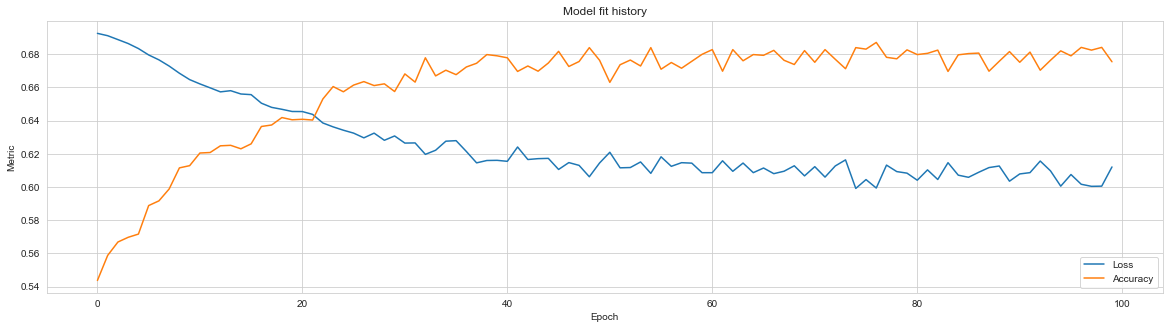

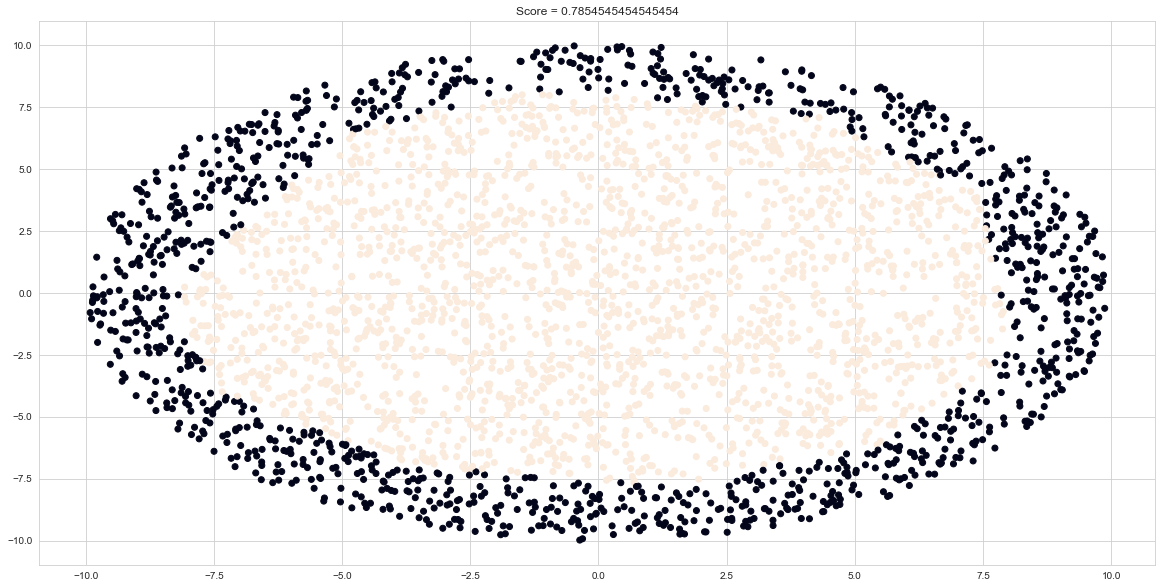

In [114]:
#########################################

def get_neural_model_opt():
    neural_model = Sequential()

    neural_model.add(L.Input(shape=X_test.shape[1]))

    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_uniform'))
    neural_model.add(L.Dropout(0.5))
    neural_model.add(L.Dense(5, activation='relu', kernel_initializer='random_uniform'))
    neural_model.add(L.Dropout(0.5))

    neural_model.add(L.Dense(2, activation='softmax'))

    optimizer = 'rmsprop'
    neural_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return neural_model


std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

my_first_neural_model = get_neural_model_opt()
fit_log = my_first_neural_model.fit(X_train_std, keras.utils.to_categorical(y_train),batch_size=145, epochs=100, workers=4, verbose=1)

predict_neural = my_first_neural_model.predict(X_test_std)
predict_classes = tf.argmax(predict_neural, axis=1).numpy()

score = accuracy_score(predict_classes, y_test)

print(f'Точность нашей модели {score}')
#########################################
plt.figure(figsize=(20, 5))
plt.title(f'Model fit history')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.plot(fit_log.history['loss'], label='Loss')
plt.plot(fit_log.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.title(f'Score = {score}')
plt.scatter(X_test['x1'], X_test['x2'], c=predict_classes)
plt.show()